# Introduction

This notebook implements Differential Evolution with Novel Parameter Control (DE-NPC) proposed by Meng et al. (2020) [1]. 

Using DE-NPC and MNIST [2], an adversarial image is generated. The prediction of an RBF Network on the adversarial image and original image is displayed.

[1] Meng, Z., Chen, Y., & Li, X. (2020). Enhancing differential evolution with novel parametercontrol. IEEE Access,8, 51145–51167. \\
[2] LeCun, Y., Cortes, C., & Burges, C.  (2010). MNIST handwritten digit database.



# Libraries

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.stats import cauchy 
from scipy import stats
import time
import operator
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from keras.models import load_model
from skimage.measure import compare_ssim as ssim
import pickle

#Set seeds
random.seed(1)
np.random.seed(1)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# DE_NPC Class

In [0]:
#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt 
import cv2 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [0]:
# https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
def euclidean(s):
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

In [0]:
class DE_NPC:
  def __init__(self,param_dict):
    ###Load Params##
    self.img = param_dict["input"]
    self.imsize = param_dict["input_size"]
    self.imclass = param_dict["imclass"]
    self.mean = param_dict["mean"]
    self.std = param_dict["std"]
    self.R_min = param_dict["R_min"]
    self.R_max = param_dict["R_max"]
    self.nfe_max = param_dict["nfe_max"]
    self.PS_ini = param_dict["PS_ini"]
    self.PS_min = param_dict["PS_min"]
    self.K = param_dict["K"]
    self.rarc = param_dict["rarc"]
    self.p = param_dict["p"]
    self.model = param_dict["model"]

    ####Initialize Params####
    self.set_params()

  #Fitness function
  def fitness_func(self,individual):
    individual = individual.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
    pred = self.model.predict(individual  / 255.0)
    pred = pred[0]
    po = pred[self.imclass]
    pred[self.imclass] = 0
    pd = np.max(pred)
    diff = pd-po
    return (0.5)*diff + (-0.5)*euclidean(individual-self.img.reshape(1,self.imsize))/(self.imsize*255) 

  #Given the population and img(whihc is necessary to calculate the fitness function)
  #choose one individual whose fitness value is in top p percent.
  def get_top_p(self,PS,p):
    num_best = int(PS*p)
    fitness =  [(individual,self.fitness_func(individual)) for individual in self.population[0:PS]]
    fitness.sort(key=lambda x: x[1])
    fitness = fitness[-num_best:]
    return random.choice(fitness)[0]

  def execute(self, model):
    not_improving = 0
    nfe = 0
    PS = self.PS_ini
    A_ind = 0
    G = 1
    start = time.time()
    while nfe < self.nfe_max:
      #############################INITIALIZATION###################################
      #Sets of successfull f and cr values
      #with the corresponding weights
      s_f = [[] for i in range(self.K)]
      s_f_weights = [[] for i in range(self.K)]
      s_cr = [[] for i in range(self.K)]
      s_cr_weights = [[] for i in range(self.K)]
      #the selected k values for this iteration
      k_selections = np.zeros((self.K,PS))
      #how many times the specific k value was a success/failure
      k_success = np.zeros((self.K,1))
      k_failure = np.zeros((self.K,1))

      ####################ADJUST POPULATION AND A###################################
      #Adjustment done due to keep the individuals' values in range.
      #and to reduce the array sizes. However, even if the population size gets 
      #smaller than PS, since the loops are in range(PS), the individuals stored in 
      #the population vector in indices > PS will not be reached. 
      #Instead of picking discarded individuals randomly, we shuffle the population
      #and archive array. It should amount to picking random.
      if G > 2:
        #Adjust the individuals of the population; 
        for i in range(PS):
          self.population[i] = np.clip(self.population[i], self.R_min, self.R_max).reshape(self.imsize)
        #Adjust storage A; 
        for i in range(self.A_size):
          self.A[i] = np.clip(self.A[i], self.R_min, self.R_max).reshape(self.imsize)
        np.random.shuffle(self.A)
        np.random.shuffle(self.population)

      #############################SELECT K,F,CR'S##################################  
      #We select a k value for each individual in the population
      #with respect to the selection probabilities (p_k) of each k.
      custm = stats.rv_discrete(name='custm', values=(np.arange(self.K).reshape(self.K,1), self.p_k))
      k_selections = custm.rvs(size=PS)
      #Get f and cr values for each individual
      for i in range(PS):
        self.cr[i]  = np.random.normal(self.mu_cr[k_selections[i]], 0.1, 1)
        if self.cr[i] < 0:
          self.cr[i] = 0
        self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        while self.f[i] <= 0:
          self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        if self.f[i] > 1:
          self.f[i] = 1
      
      ####################GENERATE U,V AND CALCULATE FITNESS########################
      #Generate donor and trial (U and V) vectors
      #Calculate the fitness values
      for i in range(PS):
        X_p_best =  self.get_top_p(PS,self.p).reshape((self.imsize,1))
        #X_r_1 denotes a random vector selection from the current population
        X_r_1 = random.choice(self.population[:PS]).reshape((self.imsize,1))
        #X_hat_r_2 denotes a randomly selected solution from the union A and P
        X_hat_r_2 = random.choice(np.concatenate((self.population[:PS], self.A[:self.A_size]), axis=0)).reshape((self.imsize,1))
        #mutation, generate trial vector
        self.V[i] = (self.population[i].reshape((self.imsize,1)) + self.f[i]*(X_p_best - self.population[i].reshape((self.imsize,1)))
               + self.f[i]*(X_r_1 - X_hat_r_2)).reshape(self.imsize)
        #crossover, generate donor vector
        self.U[i] = self.population[i]
        for j in range(self.imsize):
          if random.uniform(0, 1) <= self.cr[i]:
            self.U[i][j] = self.V[i][j]
        self.fitness_ind[i] = self.fitness_func(self.population[i])
        self.fitness_U[i] = self.fitness_func(self.U[i])

      ################################INCREMENT nfe#################################
      #Increment nfe
      nfe += PS

      #####################DETERMINE UN/SUCCESSFULL#################################
      #Determine the successful and unsuccessful cr,f,k values.
      #Add unsuccessful individuals to the archive
      for i in range(PS):
        k = k_selections[i]
        if self.fitness_ind[i] <= self.fitness_U[i]:
          s_cr[k].append(self.cr[i])
          s_cr_weights[k].append(np.std(np.subtract(self.population[i],self.U[i])))
          s_f[k].append(self.f[i])
          s_f_weights[k].append(self.fitness_U[i]-self.fitness_ind[i])
          self.population[i] = self.U[i]
          k_success[k] += 1
        else:
          if A_ind >= self.A_size:
            A_ind = 0
          self.A[A_ind] = self.population[i]
          A_ind += 1
          k_failure[k] += 1

      ######################UPDATE MU_CR AND MU_F's#################################
      #update params (mixed with Jade-like update)
      for k in range(self.K):
        if len(s_cr[k]) != 0:
          s_cr_weights[k] = s_cr_weights[k]/np.sum(s_cr_weights[k])
          s_f_weights[k] = s_f_weights[k]/np.sum(s_f_weights[k])
          mean_cr = np.sum(np.multiply(np.square(s_cr[k]),s_cr_weights[k]))/np.sum(np.multiply(s_cr[k],s_cr_weights[k]))
          mean_f = np.sum(np.multiply(np.square(s_f[k]),s_f_weights[k]))/np.sum(np.multiply(s_f[k],s_f_weights[k]))  
          #update mu_cr
          if (np.max(s_cr[k]) > 0) and (self.mu_cr[k] != 0):
            self.mu_cr[k] = mean_cr
          #update mu_f
          self.mu_f[k] = mean_f

      ###########################UPDATE GROUP PROBS#################################
      #Update group probabilities
      for k in range(self.K):
        if k_success[k] != 0:
          k_success[k] = np.square(k_success[k])/(np.sum(k_success[k])*(k_success[k]+k_failure[k]))
        else:
          self.p_k[k] = 0.000000001
      self.p_k = self.p_k/np.sum(self.p_k)

      ###########################END ITERATION######################################
      #increment generation count
      G += 1
      #Get the best individual
      self.X_best = self.get_top_p(PS,1/PS)
      if G > 2: 
        dist = euclidean(self.X_best.reshape(1,self.imsize)-self.img.reshape(1,self.imsize))/(self.imsize*255) 
        individual = self.X_best.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
        pred = self.model.predict(np.clip(individual, 0, 255)  / 255.0)
        pred = pred[0]
        pred = np.argmax(pred)
        if dist<0.001 and pred != self.imclass[0]:
          self.X_best_fitness = self.fitness_func(self.X_best)
          print("FOUND! " ,nfe, " : "  ,self.X_best_fitness,PS)
          break
        if np.abs(self.X_best_fitness-self.fitness_func(self.X_best)) < 0.001:
          not_improving += 1
          if not_improving > 30:
             self.X_best_fitness = self.fitness_func(self.X_best)
             print("NOT IMPROVING! ",nfe, " : "  ,self.X_best_fitness,PS)
             break
        else:
          not_improving = 0
        
      #Get the fitness of best individual
      self.X_best_fitness = self.fitness_func(self.X_best)
      #Give feedback
      print(nfe, " : "  ,self.X_best_fitness,PS)

      ######################ADJUST POPULATION SIZE##################################
      #adjust population size 
      #else part changed. there is something wrong with the formula on the paper.
      #since the ends of the two partial functions do not meet, when nfe > x the 
      #population increases. change is to fix this.
      if nfe <= self.x:
        PS = int(np.ceil((((self.y-self.PS_ini)/np.square(self.x-self.PS_ini))*np.square(nfe-self.PS_ini)) + self.PS_ini))
      else:
        initial_formula = int(np.floor((((self.y-self.PS_ini)/(self.x-self.PS_min))*(nfe-self.nfe_max)) + self.PS_min))
        if initial_formula < PS:
          PS = initial_formula
      #adjust archive size according to the new population
      self.A_size = int(self.rarc*PS)
      #Note: archive update moved within "Determine un/successful" as the computation
      #would be too redundant.  
    end = time.time()
    print("Time: ",end-start ," seconds")
    return end-start,nfe

  def change_input(self,img,imclass,imsize):
    self.img = img
    self.imsize = imsize
    self.imclass = imclass
    self.set_params()

  def set_params(self):
    #Calculate pivot for dynamic population change
    self.x = (1/3)*self.nfe_max
    self.y = (2/3)*self.PS_ini     
    #probability of belonging to a group
    self.p_k = np.ones((self.K,1))*(1/self.K)   
    #archive
    self.A_size = int(self.PS_ini*self.rarc)
    self.A = np.zeros((self.A_size,self.imsize))
    #scale factor
    self.f = np.ones((self.PS_ini,1)) 
    self.mu_f = np.ones((self.K,1)) *0.5
    #crossover probability
    self.cr = np.ones((self.PS_ini,1)) 
    self.mu_cr = np.ones((self.K,1)) *0.5
    #Initial population
    self.population = np.zeros((self.PS_ini,self.imsize))
    #Fitness functions
    self.fitness_ind = np.zeros((self.PS_ini,1))
    self.fitness_U = np.zeros((self.PS_ini,1))
    #donor and trial vectors
    self.V = np.zeros((self.PS_ini,self.imsize))
    self.U = np.zeros((self.PS_ini,self.imsize))
    for i in range(self.PS_ini):
      noisy_img = self.img + np.random.normal(self.mean, self.std, (self.imsize,1))
      self.population[i] = np.clip(noisy_img, 0, 255).reshape(self.imsize)
    self.X_best = None
    self.X_best_fitness = None

# Download Neural Network

In [0]:
model = load_model("CNN_CIFAR10_net3.h5")

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)       

# Prepare Data

In [0]:
import pickle
file_ = open('subset_cifar', 'rb')
dump = pickle.load(file_)
adversarial = pickle.load(file_)
dump = pickle.load(file_)
adversarial_y = pickle.load(file_)
file_.close()
del dump

# Evolve

In [0]:
param_dict = {
    "model" : model,
    #Image to be evolved
    "input" : adversarial[0].reshape((32*32,1)),
    "input_size" : 32*32,
    "imclass" : adversarial_y[0],
    #Mean and std for Gaussian noise
    #good results with 10-10
    "mean" : 0, #50(5)   #150 (1)
    "std" : 10, #50 (5) #200 (1) (it was 100)
    #Range
    "R_min" : 0.0,
    "R_max" : 255.0,
    #Maximum number of function evaluations
    "nfe_max" : 10000,#4000 #5000(6) #50000(3)  #10000 (2)
    #Initial and minimum population size
    "PS_ini" : 25, #100 #200(4)
    "PS_min" : 4,
    #Number of groups
    "K" : 7,
    #ratio of the external archive size to the whole population PS
    "rarc" : 1.6,
    #percentage p when we select an individual among top p fits
    "p" : 0.11
}

25  :  [0.42501432] 25
50  :  [0.42501432] 25
75  :  [0.4250983] 25
100  :  [0.4250983] 25
125  :  [0.4250983] 25
150  :  [0.4250983] 25
175  :  [0.42573768] 25
200  :  [0.4263744] 25
225  :  [0.4264111] 25
250  :  [0.4264136] 25
FOUND!  275  :  [0.42642468] 25
Time:  76.88481664657593  seconds
Predicted class:  [2]


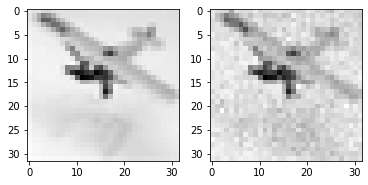

25  :  [0.2995165] 25
50  :  [0.34483024] 25
75  :  [0.35607967] 25
100  :  [0.35575932] 25
125  :  [0.35575932] 25
150  :  [0.35575932] 25
175  :  [0.35575932] 25
200  :  [0.35575932] 25
225  :  [0.35575932] 25
250  :  [0.35575932] 25
275  :  [0.35575932] 25
300  :  [0.35575932] 25
325  :  [0.35641968] 25
350  :  [0.35641968] 25
375  :  [0.35641968] 25
400  :  [0.35737255] 25
425  :  [0.35737255] 25
450  :  [0.35737255] 25
475  :  [0.35737255] 25
500  :  [0.35737255] 25
525  :  [0.35737255] 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


550  :  [0.35737255] 25
575  :  [0.35737255] 25
600  :  [0.35737255] 25
625  :  [0.35737255] 25
650  :  [0.35737255] 25
675  :  [0.35737255] 25
700  :  [0.35737255] 25
725  :  [0.35737255] 25
750  :  [0.35737255] 25
775  :  [0.35737255] 25
800  :  [0.35737255] 25
825  :  [0.35737255] 25
NOT IMPROVING!  850  :  [0.35737255] 25
Time:  233.3628649711609  seconds
Predicted class:  [2]


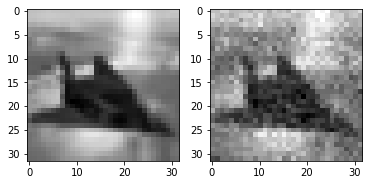

25  :  [0.39282894] 25
50  :  [0.39282894] 25
75  :  [0.39287114] 25
100  :  [0.3951894] 25
125  :  [0.3951894] 25
150  :  [0.3951894] 25
175  :  [0.39773333] 25
200  :  [0.3983542] 25
225  :  [0.3990076] 25
250  :  [0.3992192] 25
275  :  [0.39998025] 25
300  :  [0.39998025] 25
325  :  [0.39998025] 25
350  :  [0.4002756] 25
375  :  [0.40062094] 25
400  :  [0.40073082] 25
425  :  [0.40073082] 25
450  :  [0.40081346] 25
475  :  [0.40081346] 25
500  :  [0.4010687] 25
525  :  [0.40114215] 25
550  :  [0.40169108] 25
575  :  [0.40169108] 25
600  :  [0.40169108] 25
625  :  [0.40169108] 25
650  :  [0.40169108] 25
675  :  [0.4018015] 25
700  :  [0.4018015] 25
725  :  [0.4018015] 25
750  :  [0.4018015] 25
775  :  [0.4019352] 25
800  :  [0.40200442] 25
825  :  [0.40200442] 25
850  :  [0.40200704] 25
875  :  [0.40202826] 25
900  :  [0.40211806] 25
925  :  [0.40215427] 25
NOT IMPROVING!  950  :  [0.402197] 25
Time:  258.91891264915466  seconds
Predicted class:  [2]


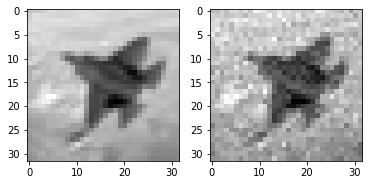

25  :  [0.3060676] 25
50  :  [0.3094423] 25
75  :  [0.31087393] 25
100  :  [0.32175934] 25
125  :  [0.32207853] 25
150  :  [0.32307976] 25
175  :  [0.32296818] 25
200  :  [0.32296818] 25
225  :  [0.32296818] 25
250  :  [0.32296818] 25
275  :  [0.32296818] 25
300  :  [0.32296818] 25
325  :  [0.32296818] 25
350  :  [0.32323265] 25
375  :  [0.3232408] 25
400  :  [0.3232408] 25
425  :  [0.3232408] 25
450  :  [0.3232408] 25
475  :  [0.3232408] 25
500  :  [0.3232408] 25
525  :  [0.3232408] 25
550  :  [0.3232408] 25
575  :  [0.3232408] 25
600  :  [0.3232408] 25
625  :  [0.3232408] 25
650  :  [0.3234679] 25
675  :  [0.3234679] 25
700  :  [0.3234679] 25
725  :  [0.3234679] 25
750  :  [0.32398915] 25
775  :  [0.32464838] 25
800  :  [0.32464838] 25
825  :  [0.3250419] 25
850  :  [0.32510763] 25
875  :  [0.32536831] 25
900  :  [0.3257679] 25
NOT IMPROVING!  925  :  [0.32605636] 25
Time:  265.338623046875  seconds
Predicted class:  [2]


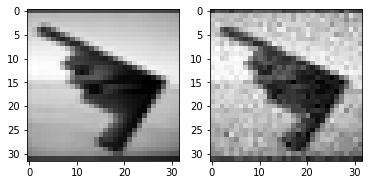

25  :  [0.36242068] 25
50  :  [0.36242068] 25
75  :  [0.36521095] 25
100  :  [0.36521095] 25
125  :  [0.36521095] 25
150  :  [0.36607057] 25
175  :  [0.36616468] 25
200  :  [0.36676836] 25
225  :  [0.36711088] 25
250  :  [0.36711088] 25
275  :  [0.3673456] 25
300  :  [0.36738795] 25
325  :  [0.36746025] 25
350  :  [0.36828232] 25
375  :  [0.36828232] 25
400  :  [0.36868146] 25
425  :  [0.3686984] 25
450  :  [0.3688285] 25
475  :  [0.36892426] 25
500  :  [0.36892474] 25
525  :  [0.3689842] 25
550  :  [0.3690213] 25
575  :  [0.36904764] 25
600  :  [0.36923808] 25
625  :  [0.36933875] 25
650  :  [0.3694252] 25
675  :  [0.3694252] 25
700  :  [0.36954558] 25
725  :  [0.36958772] 25
750  :  [0.3697487] 25
775  :  [0.369801] 25
800  :  [0.36984703] 25
825  :  [0.369909] 25
NOT IMPROVING!  850  :  [0.369909] 25
Time:  232.7676215171814  seconds
Predicted class:  [2]


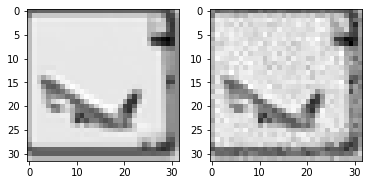

25  :  [0.42804164] 25
50  :  [0.42804164] 25
75  :  [0.42804164] 25
100  :  [0.42804164] 25
125  :  [0.42804164] 25
150  :  [0.42804164] 25
175  :  [0.42804164] 25
200  :  [0.4324514] 25
225  :  [0.43328142] 25
250  :  [0.43368158] 25
275  :  [0.43368158] 25
300  :  [0.43368158] 25
325  :  [0.43411714] 25
350  :  [0.43498197] 25
375  :  [0.43498197] 25
400  :  [0.43504152] 25
425  :  [0.43504152] 25
450  :  [0.43504152] 25
475  :  [0.43504152] 25
500  :  [0.43523216] 25
525  :  [0.43554786] 25
550  :  [0.43632042] 25
575  :  [0.4365249] 25
600  :  [0.4365249] 25
625  :  [0.43736485] 25
650  :  [0.43736485] 25
675  :  [0.43762353] 25
700  :  [0.4377819] 25
725  :  [0.43804452] 25
750  :  [0.43808576] 25
775  :  [0.4383647] 25
800  :  [0.43874568] 25
825  :  [0.43880838] 25
850  :  [0.4388271] 25
875  :  [0.4390413] 25
900  :  [0.43907556] 25
925  :  [0.43910462] 25
950  :  [0.4391562] 25
NOT IMPROVING!  975  :  [0.4391562] 25
Time:  260.77336072921753  seconds
Predicted class:  [2]


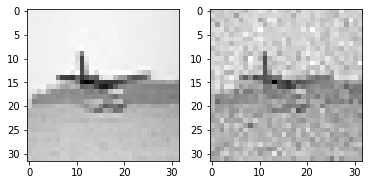

25  :  [-0.17488325] 25
50  :  [0.11487974] 25
75  :  [0.07372649] 25
100  :  [0.19127765] 25
125  :  [0.20356217] 25
150  :  [0.20617725] 25
175  :  [0.25086945] 25
200  :  [0.24772534] 25
225  :  [0.25831836] 25
250  :  [0.26050794] 25
275  :  [0.26050794] 25
300  :  [0.26050794] 25
325  :  [0.26370645] 25
350  :  [0.26369548] 25
375  :  [0.26369548] 25
400  :  [0.26369548] 25
425  :  [0.26369548] 25
450  :  [0.26425892] 25
475  :  [0.26477516] 25
500  :  [0.2655303] 25
525  :  [0.2683214] 25
550  :  [0.27021977] 25
575  :  [0.27021977] 25
600  :  [0.27021977] 25
625  :  [0.27021977] 25
650  :  [0.27136952] 25
675  :  [0.271792] 25
700  :  [0.2718191] 25
725  :  [0.27199823] 25
750  :  [0.27255845] 25
775  :  [0.27265567] 25
800  :  [0.27271453] 25
825  :  [0.27305508] 25
850  :  [0.27305508] 25
875  :  [0.27305508] 25
900  :  [0.27316093] 25
925  :  [0.27319854] 25
950  :  [0.27329156] 25
975  :  [0.2733044] 25
1000  :  [0.27336872] 25
1025  :  [0.27336872] 25
1050  :  [0.273454] 25

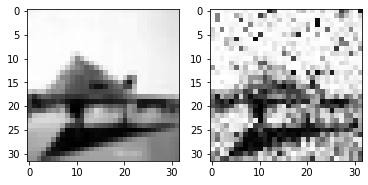

25  :  [0.2190036] 25
50  :  [0.23243734] 25
75  :  [0.27679324] 25
100  :  [0.27688646] 25
125  :  [0.28308195] 25
150  :  [0.28261483] 25
175  :  [0.28261483] 25
200  :  [0.28261483] 25
225  :  [0.28261483] 25
250  :  [0.28261483] 25
275  :  [0.28261483] 25
300  :  [0.29159003] 25
325  :  [0.29112136] 25
350  :  [0.29878506] 25
375  :  [0.2988522] 25
400  :  [0.2988522] 25
425  :  [0.30207] 25
450  :  [0.30295557] 25
475  :  [0.30304718] 25
500  :  [0.3038543] 25
525  :  [0.30475277] 25
550  :  [0.30475277] 25
575  :  [0.30475277] 25
600  :  [0.30550483] 25
625  :  [0.30550483] 25
650  :  [0.30599266] 25
675  :  [0.30596733] 25
700  :  [0.3061663] 25
725  :  [0.30640563] 25
750  :  [0.30640572] 25
775  :  [0.30664778] 25
800  :  [0.30678016] 25
825  :  [0.3068483] 25
850  :  [0.30702856] 25
875  :  [0.30715132] 25
900  :  [0.30715132] 25
925  :  [0.30715257] 25
950  :  [0.3071567] 25
975  :  [0.30719465] 25
1000  :  [0.30729133] 25
1025  :  [0.30730566] 25
1050  :  [0.30737704] 25
10

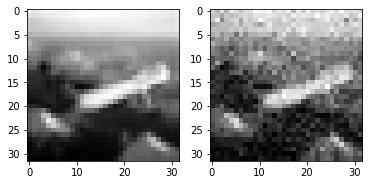

25  :  [0.13216878] 25
50  :  [0.26457196] 25
75  :  [0.2604394] 25
100  :  [0.27473298] 25
125  :  [0.30002844] 25
150  :  [0.30473572] 25
175  :  [0.30473572] 25
200  :  [0.30473572] 25
225  :  [0.3096885] 25
250  :  [0.31133056] 25
275  :  [0.31133056] 25
300  :  [0.31133056] 25
325  :  [0.31133056] 25
350  :  [0.31251377] 25
375  :  [0.31251377] 25
400  :  [0.31396323] 25
425  :  [0.31396323] 25
450  :  [0.31836885] 25
475  :  [0.32192576] 25
500  :  [0.32192576] 25
525  :  [0.32192576] 25
550  :  [0.32192576] 25
575  :  [0.32192576] 25
600  :  [0.32192576] 25
625  :  [0.32192576] 25
650  :  [0.32192576] 25
675  :  [0.32215866] 25
700  :  [0.32215866] 25
725  :  [0.3237698] 25
750  :  [0.3238778] 25
775  :  [0.3248725] 25
800  :  [0.3248725] 25
825  :  [0.3257824] 25
850  :  [0.3257824] 25
875  :  [0.3261193] 25
900  :  [0.3261193] 25
925  :  [0.3261193] 25
950  :  [0.3261193] 25
975  :  [0.32619226] 25
1000  :  [0.32619226] 25
1025  :  [0.32621235] 25
1050  :  [0.32630384] 25
1075

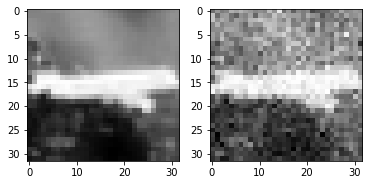

25  :  [0.43569174] 25
50  :  [0.43569174] 25
75  :  [0.43626785] 25
FOUND!  100  :  [0.43749464] 25
Time:  27.401477098464966  seconds
Predicted class:  [2]


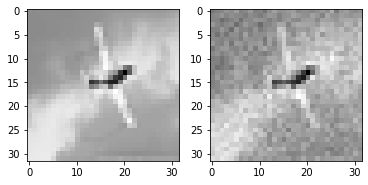

25  :  [0.32356447] 25
50  :  [0.3407405] 25
75  :  [0.35233623] 25
100  :  [0.35541707] 25
125  :  [0.35541707] 25
150  :  [0.35541707] 25
175  :  [0.35689026] 25
200  :  [0.3578052] 25
225  :  [0.35800534] 25
250  :  [0.3580373] 25
275  :  [0.3612899] 25
300  :  [0.36321986] 25
325  :  [0.36321986] 25
350  :  [0.36321986] 25
375  :  [0.36321986] 25
400  :  [0.36321986] 25
425  :  [0.36321986] 25
450  :  [0.36370087] 25
475  :  [0.36400396] 25
500  :  [0.36406517] 25
525  :  [0.36406678] 25
550  :  [0.36513272] 25
575  :  [0.36513272] 25
600  :  [0.36513272] 25
625  :  [0.36518943] 25
650  :  [0.36518943] 25
675  :  [0.36532974] 25
700  :  [0.36546692] 25
725  :  [0.36546692] 25
750  :  [0.36546692] 25
775  :  [0.36582136] 25
800  :  [0.36582136] 25
825  :  [0.36597627] 25
850  :  [0.36597627] 25
875  :  [0.36597627] 25
900  :  [0.36611354] 25
925  :  [0.36611354] 25
950  :  [0.36611354] 25
975  :  [0.36613688] 25
1000  :  [0.36617553] 25
1025  :  [0.36619455] 25
1050  :  [0.36627388]

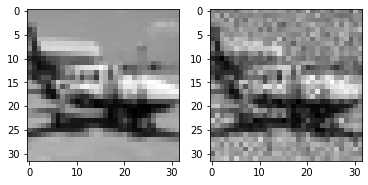

25  :  [0.38933855] 25
50  :  [0.38933855] 25
75  :  [0.38933855] 25
100  :  [0.38933855] 25
125  :  [0.3943978] 25
150  :  [0.3961994] 25
175  :  [0.3961994] 25
200  :  [0.3961994] 25
225  :  [0.39941055] 25
250  :  [0.39941055] 25
275  :  [0.39941055] 25
300  :  [0.4000076] 25
325  :  [0.4000076] 25
350  :  [0.40188307] 25
375  :  [0.40188307] 25
400  :  [0.40188307] 25
425  :  [0.40188307] 25
450  :  [0.40188307] 25
475  :  [0.40188307] 25
500  :  [0.40369657] 25
525  :  [0.40369657] 25
550  :  [0.40369657] 25
575  :  [0.40369657] 25
600  :  [0.4054137] 25
625  :  [0.4054137] 25
650  :  [0.4054137] 25
675  :  [0.4054137] 25
700  :  [0.4054137] 25
725  :  [0.4054386] 25
750  :  [0.40571302] 25
775  :  [0.40571302] 25
800  :  [0.40592387] 25
FOUND!  825  :  [0.40611413] 25
Time:  223.6527395248413  seconds
Predicted class:  [2]


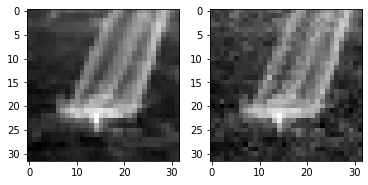

25  :  [0.2993914] 25
50  :  [0.315732] 25
75  :  [0.31240237] 25
100  :  [0.3347099] 25
125  :  [0.33474243] 25
150  :  [0.33474243] 25
175  :  [0.33595306] 25
200  :  [0.34409863] 25
225  :  [0.34524322] 25
250  :  [0.34918743] 25
275  :  [0.34937316] 25
300  :  [0.35391092] 25
325  :  [0.35391092] 25
350  :  [0.35391092] 25
375  :  [0.35391092] 25
400  :  [0.35391092] 25
425  :  [0.3563463] 25
450  :  [0.3563678] 25
475  :  [0.3563678] 25
500  :  [0.35637152] 25
525  :  [0.35724306] 25
550  :  [0.35724306] 25
575  :  [0.35724306] 25
600  :  [0.358167] 25
625  :  [0.358167] 25
650  :  [0.358167] 25
675  :  [0.3586607] 25
700  :  [0.3586607] 25
725  :  [0.3586607] 25
750  :  [0.3586607] 25
775  :  [0.35890514] 25
800  :  [0.35890514] 25
825  :  [0.358915] 25
850  :  [0.359035] 25
875  :  [0.359035] 25
900  :  [0.359035] 25
925  :  [0.3591043] 25
950  :  [0.3591379] 25
975  :  [0.35927805] 25
1000  :  [0.35927805] 25
1025  :  [0.35937715] 25
1050  :  [0.35937715] 25
1075  :  [0.3594249

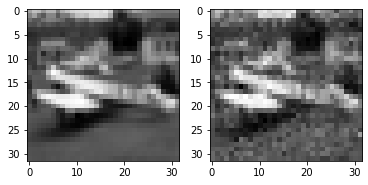

25  :  [0.2291776] 25
50  :  [0.2291776] 25
75  :  [0.23174423] 25
100  :  [0.23174423] 25
125  :  [0.23732433] 25
150  :  [0.23913959] 25
175  :  [0.23926634] 25
200  :  [0.23926634] 25
225  :  [0.23926634] 25
250  :  [0.23969704] 25
275  :  [0.23969704] 25
300  :  [0.23969704] 25
325  :  [0.23969704] 25
350  :  [0.24000177] 25
375  :  [0.24043387] 25
400  :  [0.24065891] 25
425  :  [0.24105829] 25
450  :  [0.24184152] 25
475  :  [0.24184152] 25
500  :  [0.24184152] 25
525  :  [0.24223629] 25
550  :  [0.24243173] 25
575  :  [0.24301726] 25
600  :  [0.24306303] 25
625  :  [0.24306303] 25
650  :  [0.24317652] 25
675  :  [0.24355736] 25
700  :  [0.24357837] 25
725  :  [0.24409953] 25
750  :  [0.24410355] 25
775  :  [0.24423048] 25
800  :  [0.24461254] 25
825  :  [0.24461254] 25
850  :  [0.24476603] 25
875  :  [0.24485129] 25
900  :  [0.2449156] 25
NOT IMPROVING!  925  :  [0.24499235] 25
Time:  247.88950157165527  seconds
Predicted class:  [0]


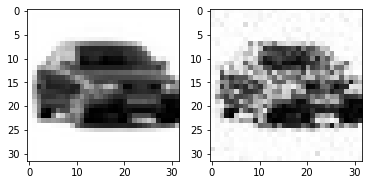

25  :  [0.29986268] 25
50  :  [0.30048078] 25
75  :  [0.30628848] 25
100  :  [0.31056964] 25
125  :  [0.31277254] 25
150  :  [0.31376183] 25
175  :  [0.31466198] 25
200  :  [0.31726003] 25
225  :  [0.31745914] 25
250  :  [0.31745914] 25
275  :  [0.3180492] 25
300  :  [0.32023308] 25
325  :  [0.3205198] 25
350  :  [0.3205198] 25
375  :  [0.3205198] 25
400  :  [0.32183033] 25
425  :  [0.32183033] 25
450  :  [0.322623] 25
475  :  [0.322623] 25
500  :  [0.32263535] 25
525  :  [0.3228473] 25
550  :  [0.32315361] 25
575  :  [0.32315361] 25
600  :  [0.32330877] 25
625  :  [0.32330877] 25
650  :  [0.32330877] 25
675  :  [0.3233784] 25
700  :  [0.32343227] 25
725  :  [0.323447] 25
750  :  [0.32352573] 25
775  :  [0.32353675] 25
800  :  [0.32356682] 25
825  :  [0.32365876] 25
850  :  [0.32371575] 25
875  :  [0.32381117] 25
900  :  [0.3238337] 25
925  :  [0.32388827] 25
950  :  [0.32394445] 25
975  :  [0.32395786] 25
1000  :  [0.32395792] 25
1025  :  [0.3239772] 25
1050  :  [0.3239851] 25
1075  :

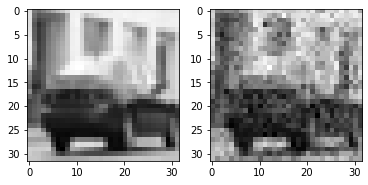

25  :  [0.30242646] 25
50  :  [0.30242646] 25
75  :  [0.31875706] 25
100  :  [0.31890392] 25
125  :  [0.31940156] 25
150  :  [0.32139468] 25
175  :  [0.32342285] 25
200  :  [0.32342285] 25
225  :  [0.32416904] 25
250  :  [0.3246132] 25
275  :  [0.3246265] 25
300  :  [0.3246265] 25
325  :  [0.3248952] 25
350  :  [0.3248952] 25
375  :  [0.32513294] 25
400  :  [0.32513294] 25
425  :  [0.32535008] 25
450  :  [0.32538155] 25
475  :  [0.32564008] 25
500  :  [0.32586327] 25
525  :  [0.3261832] 25
550  :  [0.32630587] 25
575  :  [0.32669562] 25
600  :  [0.32673728] 25
625  :  [0.32680103] 25
650  :  [0.32689285] 25
675  :  [0.32722837] 25
700  :  [0.32722837] 25
725  :  [0.32722837] 25
750  :  [0.32734656] 25
775  :  [0.32738465] 25
800  :  [0.327386] 25
825  :  [0.32750192] 25
850  :  [0.3275198] 25
875  :  [0.3275198] 25
900  :  [0.32755134] 25
925  :  [0.32763392] 25
NOT IMPROVING!  950  :  [0.32763636] 25
Time:  255.6085295677185  seconds
Predicted class:  [6]


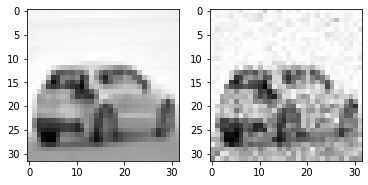

25  :  [0.3373751] 25
50  :  [0.3373751] 25
75  :  [0.35813457] 25
100  :  [0.3575322] 25
125  :  [0.37227106] 25
150  :  [0.37294024] 25
175  :  [0.37535733] 25
200  :  [0.37520134] 25
225  :  [0.37520134] 25
250  :  [0.37520134] 25
275  :  [0.37520134] 25
300  :  [0.3771273] 25
325  :  [0.3771273] 25
350  :  [0.3782575] 25
375  :  [0.37834796] 25
400  :  [0.37834796] 25
425  :  [0.38047636] 25
450  :  [0.38047636] 25
475  :  [0.38047636] 25
500  :  [0.38047636] 25
525  :  [0.38047636] 25
550  :  [0.38047636] 25
575  :  [0.38153756] 25
600  :  [0.38156962] 25
625  :  [0.38192928] 25
650  :  [0.38193336] 25
675  :  [0.38193336] 25
700  :  [0.3821267] 25
725  :  [0.3821267] 25
750  :  [0.38226184] 25
775  :  [0.38226184] 25
800  :  [0.38226184] 25
825  :  [0.3824739] 25
850  :  [0.3824739] 25
875  :  [0.38255146] 25
900  :  [0.38262254] 25
925  :  [0.38262254] 25
950  :  [0.38309926] 25
975  :  [0.3831111] 25
1000  :  [0.3835631] 25
1025  :  [0.3835631] 25
1050  :  [0.38373333] 25
1075 

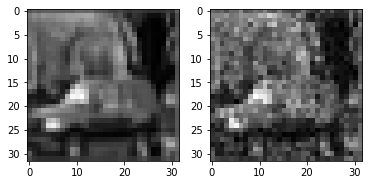

25  :  [0.36940068] 25
50  :  [0.36940068] 25
75  :  [0.37313083] 25
100  :  [0.3808754] 25
125  :  [0.38049063] 25
150  :  [0.38049063] 25
175  :  [0.38049063] 25
200  :  [0.38049063] 25
225  :  [0.38107935] 25
250  :  [0.38105643] 25
275  :  [0.38359606] 25
300  :  [0.38359606] 25
325  :  [0.38359606] 25
350  :  [0.38359606] 25
375  :  [0.38359606] 25
400  :  [0.38377744] 25
425  :  [0.38457784] 25
450  :  [0.384588] 25
475  :  [0.3854867] 25
500  :  [0.38554302] 25
525  :  [0.38554302] 25
550  :  [0.38582772] 25
575  :  [0.3862803] 25
600  :  [0.3862803] 25
625  :  [0.3862803] 25
650  :  [0.3872911] 25
675  :  [0.38729188] 25
700  :  [0.38749778] 25
725  :  [0.38749778] 25
750  :  [0.387872] 25
775  :  [0.387872] 25
800  :  [0.38794738] 25
825  :  [0.38818192] 25
850  :  [0.38818502] 25
875  :  [0.38818502] 25
900  :  [0.38827857] 25
925  :  [0.38838062] 25
950  :  [0.38838062] 25
975  :  [0.3885644] 25
1000  :  [0.3885644] 25
1025  :  [0.38875556] 25
1050  :  [0.38875556] 25
1075  

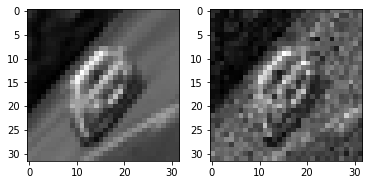

25  :  [0.32883966] 25
50  :  [0.32883966] 25
75  :  [0.32883966] 25
100  :  [0.32883966] 25
125  :  [0.32883966] 25
150  :  [0.32883966] 25
175  :  [0.32883966] 25
200  :  [0.32883966] 25
225  :  [0.32883966] 25
250  :  [0.32883966] 25
275  :  [0.3441177] 25
300  :  [0.3441177] 25
325  :  [0.3441177] 25
350  :  [0.3441177] 25
375  :  [0.3443687] 25
400  :  [0.35046047] 25
425  :  [0.35026237] 25
450  :  [0.35026237] 25
475  :  [0.35026237] 25
500  :  [0.35026237] 25
525  :  [0.35026237] 25
550  :  [0.35026237] 25
575  :  [0.35026237] 25
600  :  [0.35026237] 25
625  :  [0.35026237] 25
650  :  [0.35026237] 25
675  :  [0.35185435] 25
700  :  [0.35253757] 25
725  :  [0.352552] 25
750  :  [0.3527975] 25
775  :  [0.35282567] 25
800  :  [0.35454386] 25
825  :  [0.35463762] 25
850  :  [0.35463762] 25
875  :  [0.35463762] 25
900  :  [0.35463762] 25
925  :  [0.35463762] 25
950  :  [0.35463762] 25
975  :  [0.35463762] 25
1000  :  [0.35463762] 25
1025  :  [0.35622847] 25
1050  :  [0.35622847] 25


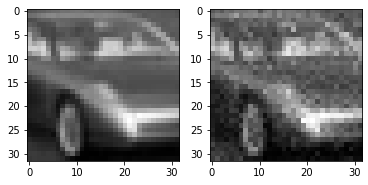

25  :  [0.23630606] 25
50  :  [0.24153897] 25
75  :  [0.25187656] 25
100  :  [0.26328737] 25
125  :  [0.26334926] 25
150  :  [0.2951411] 25
175  :  [0.29525548] 25
200  :  [0.29525548] 25
225  :  [0.31528103] 25
250  :  [0.31622267] 25
275  :  [0.31622267] 25
300  :  [0.31622267] 25
325  :  [0.31622267] 25
350  :  [0.31622267] 25
375  :  [0.31622267] 25
400  :  [0.31622267] 25
425  :  [0.31622267] 25
450  :  [0.31622267] 25
475  :  [0.31622267] 25
500  :  [0.31622267] 25
525  :  [0.31622267] 25
550  :  [0.31622267] 25
575  :  [0.31622267] 25
600  :  [0.31622267] 25
625  :  [0.31622267] 25
650  :  [0.31622267] 25
675  :  [0.32475638] 25
700  :  [0.32475638] 25
725  :  [0.32475638] 25
750  :  [0.32475638] 25
775  :  [0.32475638] 25
800  :  [0.32475638] 25
825  :  [0.32475638] 25
850  :  [0.32475638] 25
875  :  [0.32475638] 25
900  :  [0.32475638] 25
925  :  [0.32475638] 25
950  :  [0.32475638] 25
975  :  [0.32475638] 25
1000  :  [0.32475638] 25
1025  :  [0.32475638] 25
1050  :  [0.324756

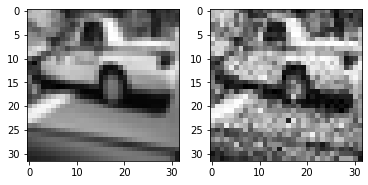

25  :  [0.32320207] 25
50  :  [0.3285175] 25
75  :  [0.37610072] 25
100  :  [0.37610072] 25
125  :  [0.37610072] 25
150  :  [0.37610072] 25
175  :  [0.37610072] 25
200  :  [0.37614745] 25
225  :  [0.37614745] 25
250  :  [0.37614745] 25
275  :  [0.37614745] 25
300  :  [0.37614745] 25
325  :  [0.37614745] 25
350  :  [0.37614745] 25
375  :  [0.37614745] 25
400  :  [0.37614745] 25
425  :  [0.37614745] 25
450  :  [0.37614745] 25
475  :  [0.37614745] 25
500  :  [0.37614745] 25
525  :  [0.37614745] 25
550  :  [0.37614745] 25
575  :  [0.37614745] 25
600  :  [0.37614745] 25
625  :  [0.37614745] 25
650  :  [0.37614745] 25
675  :  [0.37614745] 25
700  :  [0.37614745] 25
725  :  [0.37911585] 25
750  :  [0.38347417] 25
775  :  [0.38347417] 25
800  :  [0.38347417] 25
825  :  [0.38347417] 25
850  :  [0.38347417] 25
875  :  [0.38347417] 25
900  :  [0.38347417] 25
925  :  [0.38347417] 25
950  :  [0.38347417] 25
975  :  [0.38358158] 25
1000  :  [0.38358158] 25
1025  :  [0.38358158] 25
1050  :  [0.385164

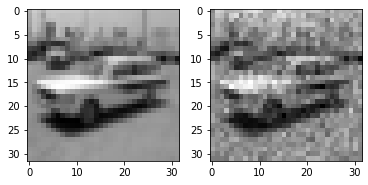

25  :  [0.20996556] 25
50  :  [0.2752327] 25
75  :  [0.30205417] 25
100  :  [0.3028854] 25
125  :  [0.3028854] 25
150  :  [0.3028854] 25
175  :  [0.30317062] 25
200  :  [0.30556324] 25
225  :  [0.31046176] 25
250  :  [0.31238076] 25
275  :  [0.31246686] 25
300  :  [0.31246686] 25
325  :  [0.31246686] 25
350  :  [0.31246686] 25
375  :  [0.31246686] 25
400  :  [0.31246686] 25
425  :  [0.31246686] 25
450  :  [0.31246686] 25
475  :  [0.31246686] 25
500  :  [0.31246686] 25
525  :  [0.31246686] 25
550  :  [0.31277347] 25
575  :  [0.31278414] 25
600  :  [0.31278414] 25
625  :  [0.31278414] 25
650  :  [0.31278414] 25
675  :  [0.31278414] 25
700  :  [0.31278414] 25
725  :  [0.31369326] 25
750  :  [0.31369326] 25
775  :  [0.31369326] 25
800  :  [0.31422585] 25
825  :  [0.31422585] 25
850  :  [0.31422585] 25
875  :  [0.31422585] 25
900  :  [0.31452167] 25
925  :  [0.31452167] 25
950  :  [0.31452167] 25
975  :  [0.31452167] 25
1000  :  [0.314586] 25
NOT IMPROVING!  1025  :  [0.31508803] 25
Time:  

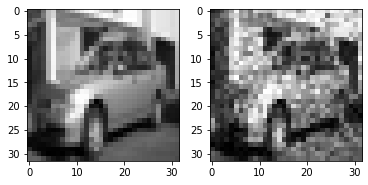

25  :  [0.36885282] 25
50  :  [0.36885282] 25
75  :  [0.36885282] 25
100  :  [0.36900684] 25
125  :  [0.3692812] 25
150  :  [0.37041175] 25
175  :  [0.3705222] 25
200  :  [0.3705222] 25
225  :  [0.3705222] 25
250  :  [0.37058222] 25
275  :  [0.37058342] 25
300  :  [0.37058342] 25
325  :  [0.3706192] 25
350  :  [0.3707853] 25
375  :  [0.3707853] 25
400  :  [0.3710392] 25
425  :  [0.37119776] 25
450  :  [0.37154782] 25
475  :  [0.37187696] 25
500  :  [0.37187696] 25
525  :  [0.37187696] 25
550  :  [0.37210524] 25
575  :  [0.37210524] 25
600  :  [0.37210524] 25
625  :  [0.37210524] 25
650  :  [0.37235278] 25
675  :  [0.37235278] 25
700  :  [0.37235278] 25
725  :  [0.37251908] 25
750  :  [0.3726223] 25
775  :  [0.3726223] 25
800  :  [0.37267506] 25
825  :  [0.37267506] 25
850  :  [0.37314665] 25
875  :  [0.37314665] 25
900  :  [0.3732511] 25
NOT IMPROVING!  925  :  [0.37340528] 25
Time:  248.9896697998047  seconds
Predicted class:  [6]


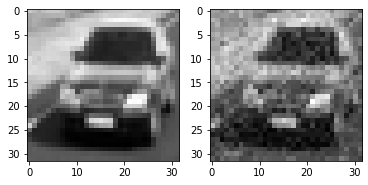

25  :  [0.32478952] 25
50  :  [0.3252826] 25
75  :  [0.34428462] 25
100  :  [0.34721708] 25
125  :  [0.34721708] 25
150  :  [0.34721708] 25
175  :  [0.34721708] 25
200  :  [0.34751892] 25
225  :  [0.34751892] 25
250  :  [0.34751892] 25
275  :  [0.34751892] 25
300  :  [0.34751892] 25
325  :  [0.34751892] 25
350  :  [0.34751892] 25
375  :  [0.34751892] 25
400  :  [0.34751892] 25
425  :  [0.34751892] 25
450  :  [0.3487377] 25
475  :  [0.34857082] 25
500  :  [0.34857082] 25
525  :  [0.34857082] 25
550  :  [0.34857082] 25
575  :  [0.34857082] 25
600  :  [0.34857082] 25
625  :  [0.34858713] 25
650  :  [0.34866667] 25
675  :  [0.35034716] 25
700  :  [0.35034716] 25
725  :  [0.35034716] 25
750  :  [0.35034716] 25
775  :  [0.35034716] 25
800  :  [0.35034716] 25
825  :  [0.3507898] 25
850  :  [0.35186797] 25
875  :  [0.35186797] 25
900  :  [0.35254204] 25
925  :  [0.35287902] 25
950  :  [0.35303932] 25
975  :  [0.35321334] 25
1000  :  [0.35321334] 25
1025  :  [0.35387266] 25
1050  :  [0.3540306]

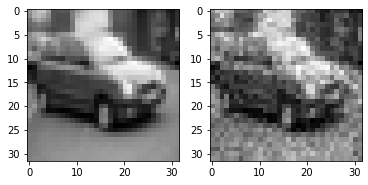

25  :  [0.31871974] 25
50  :  [0.31871974] 25
75  :  [0.31725806] 25
100  :  [0.31725806] 25
125  :  [0.3259166] 25
150  :  [0.325899] 25
175  :  [0.325899] 25
200  :  [0.32707304] 25
225  :  [0.32707304] 25
250  :  [0.32707304] 25
275  :  [0.32707304] 25
300  :  [0.32707304] 25
325  :  [0.32707304] 25
350  :  [0.32707304] 25
375  :  [0.32707304] 25
400  :  [0.32707304] 25
425  :  [0.32707304] 25
450  :  [0.32707304] 25
475  :  [0.32707304] 25
500  :  [0.32888198] 25
525  :  [0.32888198] 25
550  :  [0.32888198] 25
575  :  [0.32888198] 25
600  :  [0.32888198] 25
625  :  [0.32888198] 25
650  :  [0.32888198] 25
675  :  [0.32888198] 25
700  :  [0.32888198] 25
725  :  [0.32954103] 25
750  :  [0.3301413] 25
775  :  [0.3301413] 25
800  :  [0.3301413] 25
825  :  [0.3301413] 25
850  :  [0.33041182] 25
875  :  [0.33041182] 25
900  :  [0.33041182] 25
925  :  [0.3310425] 25
950  :  [0.33118254] 25
975  :  [0.33134323] 25
1000  :  [0.33160684] 25
1025  :  [0.33160684] 25
1050  :  [0.33160684] 25
10

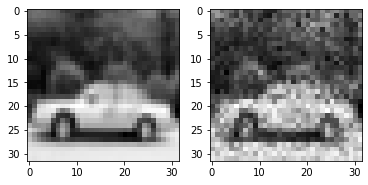

25  :  [0.16429207] 25
50  :  [0.22381358] 25
75  :  [0.29215398] 25
100  :  [0.28914165] 25
125  :  [0.28914165] 25
150  :  [0.28914165] 25
175  :  [0.28914165] 25
200  :  [0.28914165] 25
225  :  [0.2968474] 25
250  :  [0.29777604] 25
275  :  [0.29777604] 25
300  :  [0.30395687] 25
325  :  [0.30395687] 25
350  :  [0.3094312] 25
375  :  [0.30939636] 25
400  :  [0.3122403] 25
425  :  [0.31216565] 25
450  :  [0.31216565] 25
475  :  [0.3122669] 25
500  :  [0.3127756] 25
525  :  [0.31419975] 25
550  :  [0.3141641] 25
575  :  [0.3167171] 25
600  :  [0.3167171] 25
625  :  [0.3167171] 25
650  :  [0.3167171] 25
675  :  [0.31760567] 25
700  :  [0.31760567] 25
725  :  [0.31760567] 25
750  :  [0.31760567] 25
775  :  [0.31798112] 25
800  :  [0.31840268] 25
825  :  [0.31840336] 25
850  :  [0.31925145] 25
875  :  [0.3194187] 25
900  :  [0.31985193] 25
925  :  [0.31985193] 25
950  :  [0.32001978] 25
975  :  [0.32001978] 25
1000  :  [0.32006997] 25
1025  :  [0.320221] 25
1050  :  [0.32032984] 25
1075 

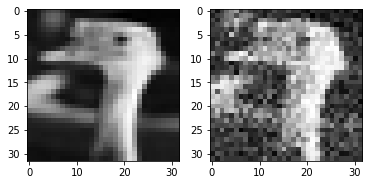

25  :  [0.3991602] 25
50  :  [0.3991602] 25
75  :  [0.3991602] 25
100  :  [0.3991602] 25
125  :  [0.3991602] 25
150  :  [0.3991602] 25
175  :  [0.3991602] 25
200  :  [0.39934558] 25
225  :  [0.39934558] 25
250  :  [0.39934558] 25
275  :  [0.39934558] 25
300  :  [0.39934558] 25
325  :  [0.39934558] 25
350  :  [0.40071204] 25
375  :  [0.4008884] 25
400  :  [0.4008884] 25
425  :  [0.4008884] 25
450  :  [0.4009385] 25
475  :  [0.40164915] 25
500  :  [0.40214747] 25
525  :  [0.40214747] 25
550  :  [0.40214747] 25
575  :  [0.40220273] 25
600  :  [0.4024626] 25
625  :  [0.40316263] 25
650  :  [0.40316263] 25
675  :  [0.40316263] 25
700  :  [0.40316772] 25
725  :  [0.40338147] 25
750  :  [0.40346733] 25
775  :  [0.40346733] 25
800  :  [0.40355596] 25
825  :  [0.40355596] 25
850  :  [0.40357882] 25
875  :  [0.40358403] 25
900  :  [0.40358403] 25
925  :  [0.4035953] 25
950  :  [0.40361005] 25
975  :  [0.40361005] 25
1000  :  [0.40361005] 25
1025  :  [0.4036175] 25
1050  :  [0.4036196] 25
1075  :

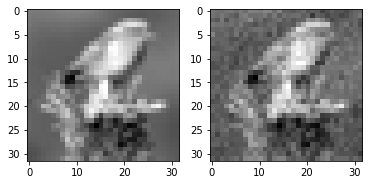

25  :  [0.41533357] 25
50  :  [0.4169234] 25
75  :  [0.4169234] 25
100  :  [0.42012736] 25
125  :  [0.42012736] 25
150  :  [0.42012736] 25
175  :  [0.42012736] 25
200  :  [0.42012736] 25
225  :  [0.42012736] 25
250  :  [0.42012736] 25
275  :  [0.42062] 25
300  :  [0.42062] 25
FOUND!  325  :  [0.4212462] 25
Time:  85.16068506240845  seconds
Predicted class:  [6]


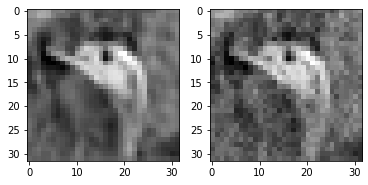

25  :  [0.19557591] 25
50  :  [0.2775346] 25
75  :  [0.30993718] 25
100  :  [0.30993718] 25
125  :  [0.30993718] 25
150  :  [0.30993718] 25
175  :  [0.30993718] 25
200  :  [0.30993718] 25
225  :  [0.31812584] 25
250  :  [0.32686353] 25
275  :  [0.32673788] 25
300  :  [0.3329451] 25
325  :  [0.3329451] 25
350  :  [0.3329451] 25
375  :  [0.3329451] 25
400  :  [0.3329451] 25
425  :  [0.3329451] 25
450  :  [0.3329451] 25
475  :  [0.3329451] 25
500  :  [0.3329451] 25
525  :  [0.33345336] 25
550  :  [0.3349165] 25
575  :  [0.3349165] 25
600  :  [0.3349165] 25
625  :  [0.33549386] 25
650  :  [0.33641422] 25
675  :  [0.33757967] 25
700  :  [0.33757967] 25
725  :  [0.33766055] 25
750  :  [0.33786184] 25
775  :  [0.33798885] 25
800  :  [0.3387143] 25
825  :  [0.33891425] 25
850  :  [0.3390224] 25
875  :  [0.3390224] 25
900  :  [0.33907157] 25
925  :  [0.33907157] 25
950  :  [0.339073] 25
975  :  [0.33908394] 25
1000  :  [0.33934766] 25
1025  :  [0.33937836] 25
1050  :  [0.3395243] 25
1075  :  [0

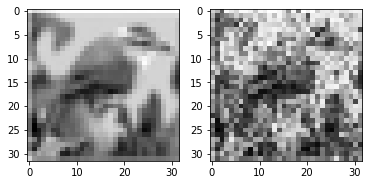

25  :  [0.13188204] 25
50  :  [0.25548607] 25
75  :  [0.17945589] 25
100  :  [0.17945589] 25
125  :  [0.17945589] 25
150  :  [0.17945589] 25
175  :  [0.17945589] 25
200  :  [0.18161343] 25
225  :  [0.18161343] 25
250  :  [0.18161343] 25
275  :  [0.18161343] 25
300  :  [0.21892841] 25
325  :  [0.21892841] 25
350  :  [0.22309153] 25
375  :  [0.21768951] 25
400  :  [0.23761682] 25
425  :  [0.23761682] 25
450  :  [0.24198693] 25
475  :  [0.24198693] 25
500  :  [0.26529157] 25
525  :  [0.26591605] 25
550  :  [0.26591605] 25
575  :  [0.26591605] 25
600  :  [0.26591605] 25
625  :  [0.26591605] 25
650  :  [0.26591605] 25
675  :  [0.26591605] 25
700  :  [0.26591605] 25
725  :  [0.26591605] 25
750  :  [0.26591605] 25
775  :  [0.2728325] 25
800  :  [0.27658957] 25
825  :  [0.27983284] 25
850  :  [0.28127497] 25
875  :  [0.28030634] 25
900  :  [0.28030634] 25
925  :  [0.28030634] 25
950  :  [0.28030634] 25
975  :  [0.28030634] 25
1000  :  [0.28030634] 25
1025  :  [0.28271982] 25
1050  :  [0.286083

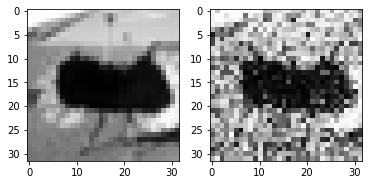

25  :  [0.24696158] 25
50  :  [0.24696158] 25
75  :  [0.29861796] 25
100  :  [0.3004691] 25
125  :  [0.3004691] 25
150  :  [0.31967258] 25
175  :  [0.31778765] 25
200  :  [0.31778765] 25
225  :  [0.32474554] 25
250  :  [0.32590437] 25
275  :  [0.34715396] 25
300  :  [0.35621673] 25
325  :  [0.35621673] 25
350  :  [0.35874796] 25
375  :  [0.35874796] 25
400  :  [0.36683774] 25
425  :  [0.36681932] 25
450  :  [0.36926338] 25
475  :  [0.36972982] 25
500  :  [0.37094226] 25
525  :  [0.37160972] 25
550  :  [0.37373343] 25
575  :  [0.37423736] 25
600  :  [0.3757084] 25
625  :  [0.3757084] 25
650  :  [0.37585956] 25
675  :  [0.37690818] 25
700  :  [0.37690818] 25
725  :  [0.3772187] 25
750  :  [0.3772187] 25
775  :  [0.37723815] 25
800  :  [0.3774639] 25
825  :  [0.37843433] 25
850  :  [0.37913457] 25
875  :  [0.37927264] 25
900  :  [0.37948552] 25
925  :  [0.37967253] 25
950  :  [0.38019907] 25
975  :  [0.38019907] 25
1000  :  [0.38019907] 25
1025  :  [0.38034004] 25
1050  :  [0.38034004] 25

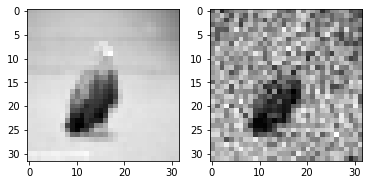

25  :  [0.17710723] 25
50  :  [0.23222068] 25
75  :  [0.20111062] 25
100  :  [0.20111062] 25
125  :  [0.26576883] 25
150  :  [0.26851967] 25
175  :  [0.26851967] 25
200  :  [0.26851967] 25
225  :  [0.2729355] 25
250  :  [0.29668152] 25
275  :  [0.29668152] 25
300  :  [0.29668152] 25
325  :  [0.31224543] 25
350  :  [0.31307632] 25
375  :  [0.31307632] 25
400  :  [0.31307632] 25
425  :  [0.31307632] 25
450  :  [0.31509107] 25
475  :  [0.31509107] 25
500  :  [0.31509107] 25
525  :  [0.31509107] 25
550  :  [0.31509107] 25
575  :  [0.31509107] 25
600  :  [0.3165984] 25
625  :  [0.3221902] 25
650  :  [0.3221889] 25
675  :  [0.32305425] 25
700  :  [0.3255711] 25
725  :  [0.32557148] 25
750  :  [0.32557148] 25
775  :  [0.32557148] 25
800  :  [0.32557148] 25
825  :  [0.32635006] 25
850  :  [0.32635006] 25
875  :  [0.32659605] 25
900  :  [0.326598] 25
925  :  [0.326598] 25
950  :  [0.32661182] 25
975  :  [0.32788026] 25
1000  :  [0.32788026] 25
1025  :  [0.32806614] 25
1050  :  [0.32843912] 25
1

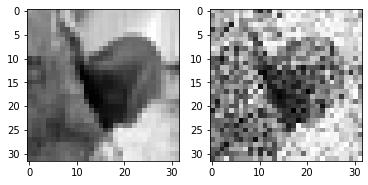

25  :  [0.18340302] 25
50  :  [0.25487837] 25
75  :  [0.29348028] 25
100  :  [0.29348028] 25
125  :  [0.29348028] 25
150  :  [0.29348028] 25
175  :  [0.305547] 25
200  :  [0.305547] 25
225  :  [0.30697927] 25
250  :  [0.31517905] 25
275  :  [0.31517905] 25
300  :  [0.31517905] 25
325  :  [0.31517905] 25
350  :  [0.31678495] 25
375  :  [0.31678495] 25
400  :  [0.31678495] 25
425  :  [0.31678495] 25
450  :  [0.32142776] 25
475  :  [0.32187116] 25
500  :  [0.3243626] 25
525  :  [0.32387292] 25
550  :  [0.3262434] 25
575  :  [0.3262434] 25
600  :  [0.3262434] 25
625  :  [0.32735413] 25
650  :  [0.3291462] 25
675  :  [0.32956773] 25
700  :  [0.3319342] 25
725  :  [0.3319342] 25
750  :  [0.3319342] 25
775  :  [0.3319342] 25
800  :  [0.33267847] 25
825  :  [0.33267847] 25
850  :  [0.33267847] 25
875  :  [0.33267847] 25
900  :  [0.33267847] 25
925  :  [0.33291072] 25
950  :  [0.33333358] 25
975  :  [0.33496803] 25
1000  :  [0.33733052] 25
1025  :  [0.33733052] 25
1050  :  [0.33733052] 25
1075 

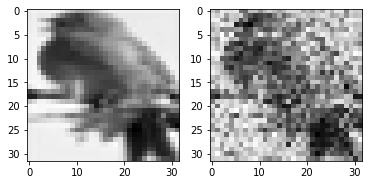

25  :  [0.16273797] 25
50  :  [0.27821508] 25
75  :  [0.2792831] 25
100  :  [0.29351038] 25
125  :  [0.34231436] 25
150  :  [0.34014642] 25
175  :  [0.34014642] 25
200  :  [0.34014642] 25
225  :  [0.3485068] 25
250  :  [0.3485068] 25
275  :  [0.35644123] 25
300  :  [0.3532443] 25
325  :  [0.35571712] 25
350  :  [0.3532443] 25
375  :  [0.35497433] 25
400  :  [0.3618844] 25
425  :  [0.3618844] 25
450  :  [0.362781] 25
475  :  [0.36428612] 25
500  :  [0.36513397] 25
525  :  [0.36484224] 25
550  :  [0.37672693] 25
575  :  [0.37674] 25
600  :  [0.37674] 25
625  :  [0.37674] 25
650  :  [0.38078502] 25
675  :  [0.38078904] 25
700  :  [0.38214502] 25
725  :  [0.38503283] 25
750  :  [0.38503283] 25
775  :  [0.38503283] 25
800  :  [0.38584742] 25
825  :  [0.38584742] 25
850  :  [0.38640305] 25
875  :  [0.38640305] 25
900  :  [0.38640305] 25
925  :  [0.38640305] 25
950  :  [0.38699648] 25
975  :  [0.38699648] 25
1000  :  [0.38736588] 25
1025  :  [0.3886087] 25
1050  :  [0.3886087] 25
1075  :  [0.

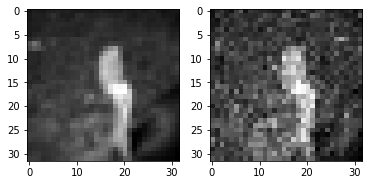

25  :  [0.31096548] 25
50  :  [0.33763564] 25
75  :  [0.3470436] 25
100  :  [0.34709185] 25
125  :  [0.34709185] 25
150  :  [0.34709185] 25
175  :  [0.34709185] 25
200  :  [0.34709185] 25
225  :  [0.3493886] 25
250  :  [0.3495875] 25
275  :  [0.34991252] 25
300  :  [0.34991252] 25
325  :  [0.34991252] 25
350  :  [0.34991252] 25
375  :  [0.34991252] 25
400  :  [0.34991252] 25
425  :  [0.34991252] 25
450  :  [0.34991252] 25
475  :  [0.34991252] 25
500  :  [0.34991252] 25
525  :  [0.34991252] 25
550  :  [0.35013744] 25
575  :  [0.35039872] 25
600  :  [0.35054368] 25
625  :  [0.350667] 25
650  :  [0.35097486] 25
675  :  [0.35116315] 25
700  :  [0.351201] 25
725  :  [0.351201] 25
750  :  [0.35148877] 25
775  :  [0.351491] 25
800  :  [0.35155556] 25
825  :  [0.35155556] 25
850  :  [0.3517918] 25
875  :  [0.35185203] 25
900  :  [0.351879] 25
925  :  [0.351879] 25
950  :  [0.35199788] 25
975  :  [0.35199788] 25
NOT IMPROVING!  1000  :  [0.3520416] 25
Time:  257.6123218536377  seconds
Predicted

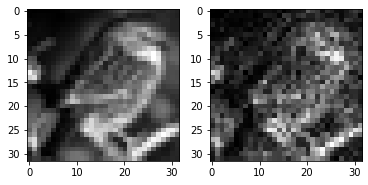

25  :  [0.1620463] 25
50  :  [0.19951755] 25
75  :  [0.31414834] 25
100  :  [0.31414834] 25
125  :  [0.31414834] 25
150  :  [0.31414834] 25
175  :  [0.31414834] 25
200  :  [0.3170492] 25
225  :  [0.3412799] 25
250  :  [0.3412171] 25
275  :  [0.3412171] 25
300  :  [0.3412171] 25
325  :  [0.3412171] 25
350  :  [0.3412171] 25
375  :  [0.3412171] 25
400  :  [0.3412171] 25
425  :  [0.3412171] 25
450  :  [0.3412171] 25
475  :  [0.3412171] 25
500  :  [0.3412171] 25
525  :  [0.3412171] 25
550  :  [0.3412171] 25
575  :  [0.3412171] 25
600  :  [0.3412171] 25
625  :  [0.34380913] 25
650  :  [0.34405652] 25
675  :  [0.34405652] 25
700  :  [0.34405652] 25
725  :  [0.34405652] 25
750  :  [0.34594733] 25
775  :  [0.34594733] 25
800  :  [0.34660217] 25
825  :  [0.34660217] 25
850  :  [0.34663516] 25
875  :  [0.34663457] 25
900  :  [0.34663457] 25
925  :  [0.34669954] 25
950  :  [0.3476119] 25
975  :  [0.3476119] 25
1000  :  [0.34781712] 25
1025  :  [0.34781608] 25
1050  :  [0.34781608] 25
1075  :  [0.

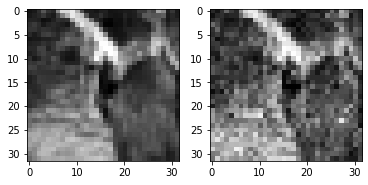

25  :  [0.10302627] 25
50  :  [0.13895968] 25
75  :  [0.1849214] 25
100  :  [0.08539316] 25
125  :  [0.27826816] 25
150  :  [0.29777905] 25
175  :  [0.3740155] 25
200  :  [0.3740155] 25
225  :  [0.3740155] 25
250  :  [0.3740155] 25
275  :  [0.3740155] 25
300  :  [0.3740155] 25
325  :  [0.3772275] 25
350  :  [0.3772275] 25
375  :  [0.37946773] 25
400  :  [0.37946773] 25
425  :  [0.37946773] 25
450  :  [0.37946773] 25
475  :  [0.37946773] 25
500  :  [0.37946773] 25
525  :  [0.3795812] 25
550  :  [0.38063022] 25
575  :  [0.380676] 25
600  :  [0.38085014] 25
625  :  [0.38085014] 25
650  :  [0.38133374] 25
675  :  [0.38133374] 25
700  :  [0.38133374] 25
725  :  [0.38133374] 25
750  :  [0.3818947] 25
775  :  [0.38273174] 25
800  :  [0.3829822] 25
825  :  [0.38348472] 25
850  :  [0.38352844] 25
875  :  [0.38352844] 25
900  :  [0.38352844] 25
925  :  [0.38352844] 25
950  :  [0.38352844] 25
975  :  [0.38354704] 25
1000  :  [0.38358676] 25
1025  :  [0.3841249] 25
1050  :  [0.38445595] 25
1075  :

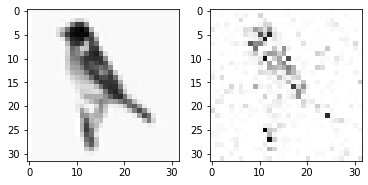

25  :  [0.19189833] 25
50  :  [0.28741693] 25
75  :  [0.23882166] 25
100  :  [0.23882166] 25
125  :  [0.24696279] 25
150  :  [0.26141012] 25
175  :  [0.27146006] 25
200  :  [0.27146006] 25
225  :  [0.27146006] 25
250  :  [0.27146006] 25
275  :  [0.27146006] 25
300  :  [0.27146006] 25
325  :  [0.27146006] 25
350  :  [0.27146006] 25
375  :  [0.27146006] 25
400  :  [0.28865182] 25
425  :  [0.323913] 25
450  :  [0.32420868] 25
475  :  [0.32420868] 25
500  :  [0.35267004] 25
525  :  [0.3526026] 25
550  :  [0.35593823] 25
575  :  [0.35594493] 25
600  :  [0.35594493] 25
625  :  [0.36029795] 25
650  :  [0.3685344] 25
675  :  [0.37221965] 25
700  :  [0.37223643] 25
725  :  [0.37223643] 25
750  :  [0.37292165] 25
775  :  [0.37292165] 25
800  :  [0.37292165] 25
825  :  [0.3749324] 25
850  :  [0.3749324] 25
875  :  [0.37552306] 25
900  :  [0.37582085] 25
925  :  [0.37611616] 25
950  :  [0.37611616] 25
975  :  [0.37690628] 25
1000  :  [0.3769153] 25
1025  :  [0.3771926] 25
1050  :  [0.3771989] 25
1

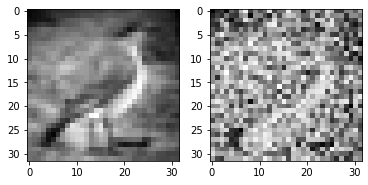

25  :  [-0.19332443] 25
50  :  [0.08165826] 25
75  :  [0.16374555] 25
100  :  [0.21796578] 25
125  :  [0.21796578] 25
150  :  [0.22324146] 25
175  :  [0.26366445] 25
200  :  [0.26366445] 25
225  :  [0.26366445] 25
250  :  [0.2745466] 25
275  :  [0.28101608] 25
300  :  [0.2809927] 25
325  :  [0.2809927] 25
350  :  [0.2809927] 25
375  :  [0.28599742] 25
400  :  [0.31985003] 25
425  :  [0.3224455] 25
450  :  [0.33298948] 25
475  :  [0.33298948] 25
500  :  [0.33298948] 25
525  :  [0.33298948] 25
550  :  [0.33298948] 25
575  :  [0.33298948] 25
600  :  [0.33298948] 25
625  :  [0.33298948] 25
650  :  [0.33298948] 25
675  :  [0.33298948] 25
700  :  [0.33298948] 25
725  :  [0.33298948] 25
750  :  [0.3351941] 25
775  :  [0.33514786] 25
800  :  [0.34425652] 25
825  :  [0.344257] 25
850  :  [0.344257] 25
875  :  [0.34794858] 25
900  :  [0.34794945] 25
925  :  [0.34830767] 25
950  :  [0.34828642] 25
975  :  [0.34914738] 25
1000  :  [0.34914738] 25
1025  :  [0.3493564] 25
1050  :  [0.3494225] 25
107

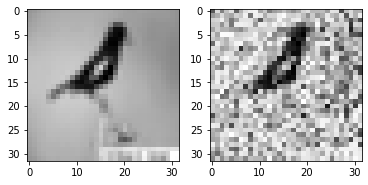

25  :  [0.3719239] 25
50  :  [0.3719239] 25
75  :  [0.3725303] 25
100  :  [0.37278822] 25
125  :  [0.37330115] 25
150  :  [0.3734083] 25
175  :  [0.37346515] 25
200  :  [0.37382942] 25
225  :  [0.37382942] 25
250  :  [0.37382942] 25
FOUND!  275  :  [0.37398788] 25
Time:  74.22764825820923  seconds
Predicted class:  [2]


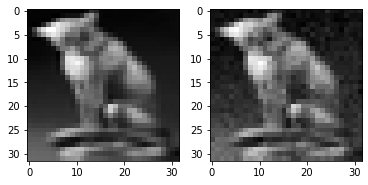

25  :  [0.29558676] 25
50  :  [0.29618633] 25
75  :  [0.32895178] 25
100  :  [0.33938283] 25
125  :  [0.33985385] 25
150  :  [0.34584597] 25
175  :  [0.34499723] 25
200  :  [0.37156272] 25
225  :  [0.37207788] 25
250  :  [0.37207788] 25
275  :  [0.37207788] 25
300  :  [0.37207788] 25
325  :  [0.37207788] 25
350  :  [0.37207788] 25
375  :  [0.37207788] 25
400  :  [0.37207788] 25
425  :  [0.37207788] 25
450  :  [0.37207788] 25
475  :  [0.376862] 25
500  :  [0.37678248] 25
525  :  [0.37785625] 25
550  :  [0.377964] 25
575  :  [0.3777921] 25
600  :  [0.3777921] 25
625  :  [0.3777921] 25
650  :  [0.37838796] 25
675  :  [0.3795729] 25
700  :  [0.37987497] 25
725  :  [0.3798757] 25
750  :  [0.38308638] 25
775  :  [0.38306338] 25
800  :  [0.38306338] 25
825  :  [0.38306338] 25
850  :  [0.38306338] 25
875  :  [0.3834179] 25
900  :  [0.38342163] 25
925  :  [0.3849401] 25
950  :  [0.38554585] 25
975  :  [0.3874407] 25
1000  :  [0.3874407] 25
1025  :  [0.3874407] 25
1050  :  [0.3874407] 25
1075  :

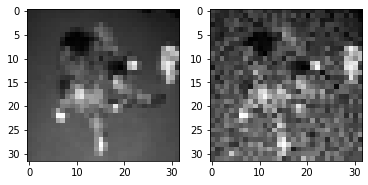

25  :  [0.10419118] 25
50  :  [0.13699305] 25
75  :  [0.29592305] 25
100  :  [0.29592305] 25
125  :  [0.29592305] 25
150  :  [0.29592305] 25
175  :  [0.29592305] 25
200  :  [0.2967121] 25
225  :  [0.29592305] 25
250  :  [0.2989971] 25
275  :  [0.29862761] 25
300  :  [0.30000168] 25
325  :  [0.30000168] 25
350  :  [0.30000168] 25
375  :  [0.30000168] 25
400  :  [0.30000168] 25
425  :  [0.30000168] 25
450  :  [0.30000168] 25
475  :  [0.30000168] 25
500  :  [0.30000168] 25
525  :  [0.30100316] 25
550  :  [0.30089974] 25
575  :  [0.30099386] 25
600  :  [0.3015247] 25
625  :  [0.3015247] 25
650  :  [0.30209398] 25
675  :  [0.30257645] 25
700  :  [0.30276895] 25
725  :  [0.30278903] 25
750  :  [0.30332357] 25
775  :  [0.30332357] 25
800  :  [0.3035019] 25
825  :  [0.30351007] 25
850  :  [0.3036211] 25
875  :  [0.3036211] 25
900  :  [0.30367666] 25
925  :  [0.30389422] 25
950  :  [0.3039254] 25
975  :  [0.30398637] 25
1000  :  [0.3040676] 25
1025  :  [0.30409497] 25
1050  :  [0.3041584] 25
10

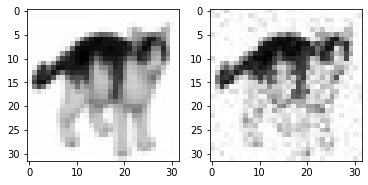

25  :  [0.25351974] 25
50  :  [0.25536525] 25
75  :  [0.2494039] 25
100  :  [0.25494877] 25
125  :  [0.33201116] 25
150  :  [0.3299342] 25
175  :  [0.3299342] 25
200  :  [0.3299342] 25
225  :  [0.3299342] 25
250  :  [0.3299342] 25
275  :  [0.3299342] 25
300  :  [0.3299342] 25
325  :  [0.3299342] 25
350  :  [0.3299342] 25
375  :  [0.3299342] 25
400  :  [0.3299342] 25
425  :  [0.3299342] 25
450  :  [0.3299342] 25
475  :  [0.3299342] 25
500  :  [0.33334252] 25
525  :  [0.33321965] 25
550  :  [0.33321965] 25
575  :  [0.33321965] 25
600  :  [0.33321965] 25
625  :  [0.33321965] 25
650  :  [0.33453256] 25
675  :  [0.33487016] 25
700  :  [0.33670506] 25
725  :  [0.3375566] 25
750  :  [0.33824927] 25
775  :  [0.33827043] 25
800  :  [0.3412401] 25
825  :  [0.3412401] 25
850  :  [0.3418426] 25
875  :  [0.3418426] 25
900  :  [0.34223774] 25
925  :  [0.34330732] 25
950  :  [0.34330732] 25
975  :  [0.34330732] 25
1000  :  [0.34330732] 25
1025  :  [0.34392178] 25
1050  :  [0.34433085] 25
1075  :  [0.

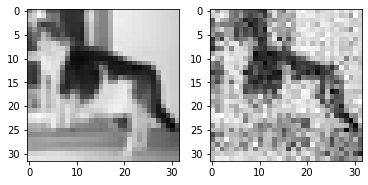

25  :  [0.33866003] 25
50  :  [0.34264925] 25
75  :  [0.34334442] 25
100  :  [0.34334975] 25
125  :  [0.343992] 25
150  :  [0.34462366] 25
175  :  [0.344665] 25
200  :  [0.3449666] 25
225  :  [0.34499496] 25
250  :  [0.34499496] 25
275  :  [0.34577212] 25
300  :  [0.34577212] 25
325  :  [0.34577212] 25
350  :  [0.34581643] 25
375  :  [0.34613255] 25
400  :  [0.34613255] 25
425  :  [0.346599] 25
450  :  [0.346599] 25
475  :  [0.34689745] 25
500  :  [0.34689745] 25
525  :  [0.34689745] 25
550  :  [0.3470009] 25
575  :  [0.34761205] 25
600  :  [0.34761205] 25
625  :  [0.3478029] 25
650  :  [0.3478029] 25
675  :  [0.3478158] 25
700  :  [0.3478158] 25
725  :  [0.3478158] 25
750  :  [0.3478158] 25
775  :  [0.3478158] 25
800  :  [0.3478158] 25
NOT IMPROVING!  825  :  [0.34792238] 25
Time:  227.21256685256958  seconds
Predicted class:  [2]


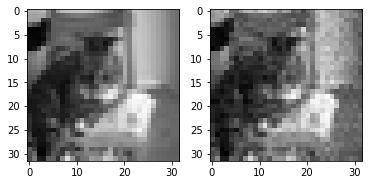

25  :  [0.33929744] 25
50  :  [0.37070763] 25
75  :  [0.3802613] 25
100  :  [0.38890097] 25
125  :  [0.38908654] 25
150  :  [0.39809042] 25
175  :  [0.39996573] 25
200  :  [0.4000498] 25
225  :  [0.4000498] 25
250  :  [0.4000498] 25
275  :  [0.4000498] 25
300  :  [0.40018827] 25
325  :  [0.40018827] 25
350  :  [0.40018827] 25
375  :  [0.40018827] 25
400  :  [0.40018827] 25
425  :  [0.40018827] 25
450  :  [0.40018827] 25
475  :  [0.40042955] 25
500  :  [0.40129066] 25
525  :  [0.40129086] 25
550  :  [0.40143] 25
575  :  [0.40143] 25
600  :  [0.40245128] 25
625  :  [0.4054065] 25
650  :  [0.4054065] 25
675  :  [0.4054065] 25
700  :  [0.4054065] 25
725  :  [0.4054065] 25
750  :  [0.4054065] 25
775  :  [0.4054065] 25
800  :  [0.40552837] 25
825  :  [0.40552837] 25
850  :  [0.40552837] 25
875  :  [0.40572152] 25
900  :  [0.4057399] 25
925  :  [0.4057399] 25
950  :  [0.40647757] 25
975  :  [0.40647757] 25
1000  :  [0.40647757] 25
1025  :  [0.40647757] 25
1050  :  [0.40647757] 25
1075  :  [0.

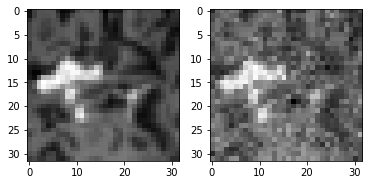

25  :  [0.2725672] 25
50  :  [0.32572457] 25
75  :  [0.32556725] 25
100  :  [0.32556725] 25
125  :  [0.32556725] 25
150  :  [0.32556725] 25
175  :  [0.32556725] 25
200  :  [0.32556725] 25
225  :  [0.32556725] 25
250  :  [0.32556725] 25
275  :  [0.32556725] 25
300  :  [0.32556725] 25
325  :  [0.32556725] 25
350  :  [0.32919997] 25
375  :  [0.32919997] 25
400  :  [0.32919997] 25
425  :  [0.32919997] 25
450  :  [0.32919997] 25
475  :  [0.32919997] 25
500  :  [0.33441478] 25
525  :  [0.33444443] 25
550  :  [0.33644643] 25
575  :  [0.33723918] 25
600  :  [0.34053713] 25
625  :  [0.34053713] 25
650  :  [0.34053713] 25
675  :  [0.3419041] 25
700  :  [0.3419041] 25
725  :  [0.3419041] 25
750  :  [0.3419041] 25
775  :  [0.3419041] 25
800  :  [0.3419041] 25
825  :  [0.34192035] 25
850  :  [0.34192035] 25
875  :  [0.34422633] 25
900  :  [0.34422633] 25
925  :  [0.3452441] 25
950  :  [0.3452441] 25
975  :  [0.3452441] 25
1000  :  [0.3452441] 25
1025  :  [0.3453732] 25
1050  :  [0.3454458] 25
1075 

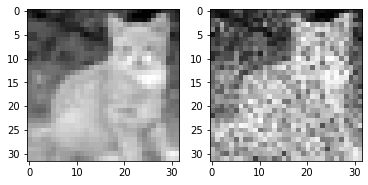

25  :  [0.265623] 25
50  :  [0.29663205] 25
75  :  [0.30274075] 25
100  :  [0.30284327] 25
125  :  [0.30284327] 25
150  :  [0.3077981] 25
175  :  [0.3077981] 25
200  :  [0.3092363] 25
225  :  [0.30927572] 25
250  :  [0.30927572] 25
275  :  [0.3101415] 25
300  :  [0.3113109] 25
325  :  [0.3113109] 25
350  :  [0.31348252] 25
375  :  [0.3134014] 25
400  :  [0.3134014] 25
425  :  [0.31522924] 25
450  :  [0.31620723] 25
475  :  [0.31641215] 25
500  :  [0.3168779] 25
525  :  [0.3168779] 25
550  :  [0.31695694] 25
575  :  [0.3175549] 25
600  :  [0.31851488] 25
625  :  [0.3186109] 25
650  :  [0.3188855] 25
675  :  [0.3188855] 25
700  :  [0.31902492] 25
725  :  [0.31924206] 25
750  :  [0.31924206] 25
775  :  [0.31924206] 25
800  :  [0.31933808] 25
825  :  [0.31934905] 25
850  :  [0.31941986] 25
875  :  [0.31958795] 25
900  :  [0.31958795] 25
925  :  [0.31964815] 25
950  :  [0.3197124] 25
975  :  [0.31980497] 25
1000  :  [0.32001173] 25
1025  :  [0.32001173] 25
1050  :  [0.32008776] 25
1075  :  

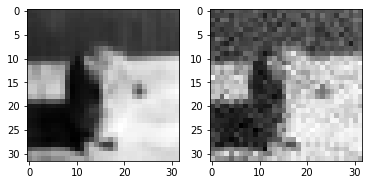

25  :  [0.16141015] 25
50  :  [0.16141015] 25
75  :  [0.2071915] 25
100  :  [0.20460455] 25
125  :  [0.22964828] 25
150  :  [0.25753194] 25
175  :  [0.2585384] 25
200  :  [0.26850745] 25
225  :  [0.27210504] 25
250  :  [0.27361408] 25
275  :  [0.27361408] 25
300  :  [0.27361408] 25
325  :  [0.27361408] 25
350  :  [0.2753392] 25
375  :  [0.279478] 25
400  :  [0.2827012] 25
425  :  [0.28285453] 25
450  :  [0.28285453] 25
475  :  [0.28313786] 25
500  :  [0.2847538] 25
525  :  [0.28955376] 25
550  :  [0.28955376] 25
575  :  [0.29300815] 25
600  :  [0.29483977] 25
625  :  [0.29483977] 25
650  :  [0.29613945] 25
675  :  [0.2964679] 25
700  :  [0.2964679] 25
725  :  [0.29837263] 25
750  :  [0.29871634] 25
775  :  [0.29969588] 25
800  :  [0.29975522] 25
825  :  [0.29975522] 25
850  :  [0.30059767] 25
875  :  [0.30087107] 25
900  :  [0.30093312] 25
925  :  [0.30093312] 25
950  :  [0.30093312] 25
975  :  [0.30093312] 25
1000  :  [0.30093312] 25
1025  :  [0.30093312] 25
1050  :  [0.3009804] 25
10

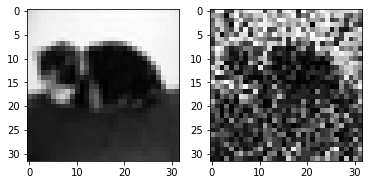

25  :  [0.29423085] 25
50  :  [0.32644176] 25
75  :  [0.342986] 25
100  :  [0.342986] 25
125  :  [0.342986] 25
150  :  [0.342986] 25
175  :  [0.342986] 25
200  :  [0.342986] 25
225  :  [0.34447438] 25
250  :  [0.3509648] 25
275  :  [0.3505408] 25
300  :  [0.3505408] 25
325  :  [0.3505408] 25
350  :  [0.3505408] 25
375  :  [0.3505408] 25
400  :  [0.3505408] 25
425  :  [0.3505408] 25
450  :  [0.3505408] 25
475  :  [0.3505408] 25
500  :  [0.3505408] 25
525  :  [0.3505408] 25
550  :  [0.3505408] 25
575  :  [0.3505408] 25
600  :  [0.3505408] 25
625  :  [0.3505408] 25
650  :  [0.3505408] 25
675  :  [0.3505408] 25
700  :  [0.3505408] 25
725  :  [0.3505408] 25
750  :  [0.3505408] 25
775  :  [0.3505408] 25
800  :  [0.3505408] 25
825  :  [0.3505408] 25
850  :  [0.3505408] 25
875  :  [0.3505408] 25
900  :  [0.3505408] 25
925  :  [0.3505408] 25
950  :  [0.3505408] 25
975  :  [0.3505408] 25
1000  :  [0.3505408] 25
NOT IMPROVING!  1025  :  [0.3505408] 25
Time:  306.57165241241455  seconds
Predicted 

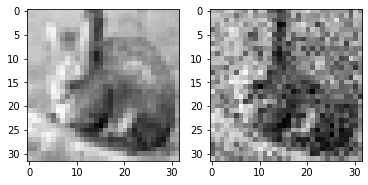

25  :  [0.13939986] 25
50  :  [0.13939986] 25
75  :  [0.185285] 25
100  :  [0.185285] 25
125  :  [0.185285] 25
150  :  [0.18555248] 25
175  :  [0.185285] 25
200  :  [0.20569146] 25
225  :  [0.20569146] 25
250  :  [0.2196401] 25
275  :  [0.22130552] 25
300  :  [0.22130552] 25
325  :  [0.22130552] 25
350  :  [0.22130552] 25
375  :  [0.22130552] 25
400  :  [0.22456837] 25
425  :  [0.2299647] 25
450  :  [0.2299172] 25
475  :  [0.2299172] 25
500  :  [0.2299172] 25
525  :  [0.2299172] 25
550  :  [0.2299172] 25
575  :  [0.23045883] 25
600  :  [0.23045883] 25
625  :  [0.23045883] 25
650  :  [0.2309441] 25
675  :  [0.23111176] 25
700  :  [0.23111176] 25
725  :  [0.23111176] 25
750  :  [0.23111176] 25
775  :  [0.23111176] 25
800  :  [0.23111176] 25
825  :  [0.23111176] 25
850  :  [0.23111176] 25
875  :  [0.23113826] 25
900  :  [0.23205355] 25
925  :  [0.2322622] 25
950  :  [0.23244736] 25
975  :  [0.23386952] 25
1000  :  [0.23395294] 25
1025  :  [0.23395294] 25
1050  :  [0.23400187] 25
1075  :  

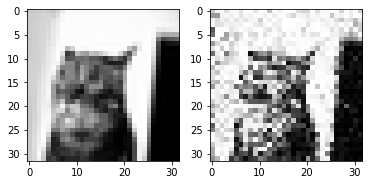

25  :  [0.3762214] 25
50  :  [0.3762214] 25
75  :  [0.3762214] 25
100  :  [0.3762214] 25
125  :  [0.37810183] 25
150  :  [0.37810183] 25
175  :  [0.37810183] 25
200  :  [0.37810183] 25
225  :  [0.37810183] 25
250  :  [0.37885162] 25
275  :  [0.3792452] 25
300  :  [0.38077062] 25
325  :  [0.38088503] 25
350  :  [0.38103035] 25
375  :  [0.38103035] 25
400  :  [0.38103035] 25
425  :  [0.38103035] 25
450  :  [0.38115904] 25
475  :  [0.38115904] 25
500  :  [0.3818238] 25
525  :  [0.3818238] 25
550  :  [0.3819632] 25
575  :  [0.3819632] 25
600  :  [0.38211036] 25
625  :  [0.38245404] 25
650  :  [0.38245404] 25
675  :  [0.38245404] 25
700  :  [0.3824616] 25
725  :  [0.38257542] 25
750  :  [0.382677] 25
775  :  [0.38272455] 25
800  :  [0.38272455] 25
825  :  [0.38281214] 25
850  :  [0.38289154] 25
875  :  [0.38304916] 25
900  :  [0.38305014] 25
925  :  [0.38314322] 25
950  :  [0.38320124] 25
975  :  [0.38322333] 25
1000  :  [0.38330212] 25
1025  :  [0.38332734] 25
1050  :  [0.38332734] 25
NOT 

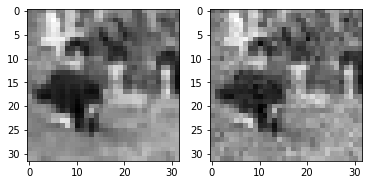

25  :  [0.3674284] 25
50  :  [0.36934948] 25
75  :  [0.37201312] 25
100  :  [0.372094] 25
125  :  [0.372094] 25
150  :  [0.372094] 25
175  :  [0.372094] 25
200  :  [0.3721528] 25
225  :  [0.3721794] 25
250  :  [0.3721794] 25
275  :  [0.3721794] 25
300  :  [0.3721794] 25
325  :  [0.37270075] 25
350  :  [0.37305298] 25
375  :  [0.37305298] 25
400  :  [0.373352] 25
425  :  [0.37382638] 25
450  :  [0.37399027] 25
475  :  [0.37399027] 25
500  :  [0.3742324] 25
525  :  [0.3742324] 25
550  :  [0.37449265] 25
575  :  [0.37449265] 25
600  :  [0.37455732] 25
625  :  [0.37455732] 25
650  :  [0.37464333] 25
675  :  [0.37483406] 25
700  :  [0.37483504] 25
725  :  [0.37483504] 25
750  :  [0.37487555] 25
775  :  [0.37492648] 25
800  :  [0.3749529] 25
825  :  [0.37509418] 25
NOT IMPROVING!  850  :  [0.37513453] 25
Time:  244.73137664794922  seconds
Predicted class:  [6]


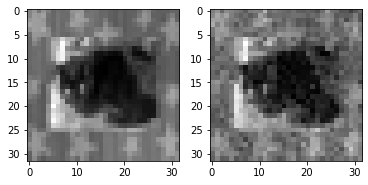

25  :  [-0.25990152] 25
50  :  [0.00286599] 25
75  :  [0.27648515] 25
100  :  [0.31365168] 25
125  :  [0.31365168] 25
150  :  [0.31365168] 25
175  :  [0.3178026] 25
200  :  [0.31820774] 25
225  :  [0.33152902] 25
250  :  [0.33737168] 25
275  :  [0.33966583] 25
300  :  [0.3397818] 25
325  :  [0.34472913] 25
350  :  [0.3471194] 25
375  :  [0.34711576] 25
400  :  [0.34860095] 25
425  :  [0.34908107] 25
450  :  [0.3501196] 25
475  :  [0.35091934] 25
500  :  [0.35091934] 25
525  :  [0.3521188] 25
550  :  [0.3521188] 25
575  :  [0.35235214] 25
600  :  [0.35235214] 25
625  :  [0.35235214] 25
650  :  [0.35235214] 25
675  :  [0.3524874] 25
700  :  [0.3524874] 25
725  :  [0.3526806] 25
750  :  [0.3527145] 25
775  :  [0.35278702] 25
800  :  [0.35278702] 25
825  :  [0.35293356] 25
850  :  [0.35306853] 25
875  :  [0.35306853] 25
900  :  [0.35308927] 25
925  :  [0.35315794] 25
950  :  [0.35320422] 25
975  :  [0.35320422] 25
1000  :  [0.35322115] 25
1025  :  [0.35322115] 25
1050  :  [0.35322565] 25
1

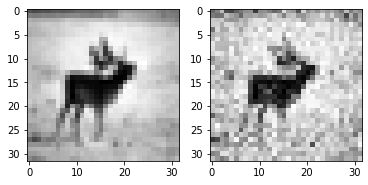

25  :  [0.2872494] 25
50  :  [0.292014] 25
75  :  [0.27503535] 25
100  :  [0.2967412] 25
125  :  [0.31133252] 25
150  :  [0.31707573] 25
175  :  [0.32338876] 25
200  :  [0.3320986] 25
225  :  [0.335915] 25
250  :  [0.33566368] 25
275  :  [0.33566368] 25
300  :  [0.33566368] 25
325  :  [0.33566368] 25
350  :  [0.33586854] 25
375  :  [0.33779326] 25
400  :  [0.33884194] 25
425  :  [0.33884758] 25
450  :  [0.33884758] 25
475  :  [0.3389345] 25
500  :  [0.33966488] 25
525  :  [0.3400401] 25
550  :  [0.3429101] 25
575  :  [0.34298334] 25
600  :  [0.34298334] 25
625  :  [0.3443057] 25
650  :  [0.3458961] 25
675  :  [0.34645933] 25
700  :  [0.34645933] 25
725  :  [0.34645933] 25
750  :  [0.34670174] 25
775  :  [0.34670174] 25
800  :  [0.34709543] 25
825  :  [0.34716815] 25
850  :  [0.3476267] 25
875  :  [0.34787154] 25
900  :  [0.34792554] 25
925  :  [0.34798884] 25
950  :  [0.34801108] 25
975  :  [0.34821808] 25
1000  :  [0.34821808] 25
1025  :  [0.34821808] 25
1050  :  [0.34822047] 25
1075 

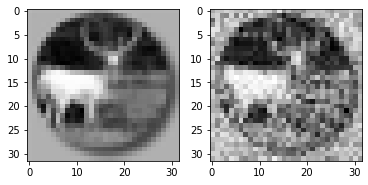

25  :  [0.41160643] 25
50  :  [0.41160643] 25
75  :  [0.41160643] 25
100  :  [0.41254616] 25
125  :  [0.41536647] 25
150  :  [0.41554838] 25
175  :  [0.41886494] 25
200  :  [0.4218361] 25
225  :  [0.4218361] 25
250  :  [0.4218361] 25
275  :  [0.4218361] 25
300  :  [0.42324525] 25
325  :  [0.4232576] 25
350  :  [0.4232576] 25
375  :  [0.4232576] 25
400  :  [0.42378527] 25
425  :  [0.42378527] 25
450  :  [0.4240967] 25
475  :  [0.4240967] 25
500  :  [0.4240967] 25
525  :  [0.4243879] 25
550  :  [0.42455798] 25
575  :  [0.42455798] 25
600  :  [0.42471808] 25
625  :  [0.4247252] 25
650  :  [0.42483753] 25
675  :  [0.42485008] 25
700  :  [0.4249038] 25
725  :  [0.4249038] 25
750  :  [0.4250998] 25
775  :  [0.4250998] 25
800  :  [0.4251874] 25
825  :  [0.4251874] 25
850  :  [0.4251874] 25
875  :  [0.42537084] 25
900  :  [0.42537084] 25
925  :  [0.42543644] 25
950  :  [0.42543644] 25
975  :  [0.4254421] 25
1000  :  [0.42551458] 25
1025  :  [0.42553818] 25
1050  :  [0.4255616] 25
NOT IMPROVING

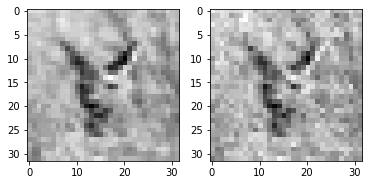

25  :  [0.32074884] 25
50  :  [0.32074884] 25
75  :  [0.32851344] 25
100  :  [0.329514] 25
125  :  [0.33140594] 25
150  :  [0.333941] 25
175  :  [0.333941] 25
200  :  [0.33478063] 25
225  :  [0.33516914] 25
250  :  [0.33516914] 25
275  :  [0.33525378] 25
300  :  [0.34167367] 25
325  :  [0.34167367] 25
350  :  [0.34167367] 25
375  :  [0.34167367] 25
400  :  [0.34434557] 25
425  :  [0.3448538] 25
450  :  [0.3448538] 25
475  :  [0.3448538] 25
500  :  [0.34574997] 25
525  :  [0.34721518] 25
550  :  [0.34721518] 25
575  :  [0.34721518] 25
600  :  [0.34721518] 25
625  :  [0.34768742] 25
650  :  [0.3481306] 25
675  :  [0.3481306] 25
700  :  [0.34885496] 25
725  :  [0.34885496] 25
750  :  [0.34948692] 25
775  :  [0.34948692] 25
800  :  [0.34948692] 25
825  :  [0.3495227] 25
850  :  [0.3497728] 25
875  :  [0.3497728] 25
900  :  [0.3497728] 25
925  :  [0.34983373] 25
950  :  [0.34983373] 25
975  :  [0.34983373] 25
1000  :  [0.35000694] 25
1025  :  [0.35000694] 25
1050  :  [0.35000694] 25
1075  :

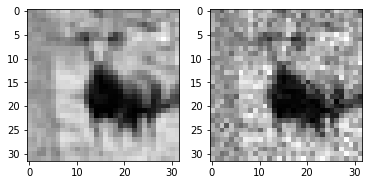

25  :  [0.4469287] 25
50  :  [0.4469287] 25
75  :  [0.45061323] 25
100  :  [0.45325115] 25
125  :  [0.45573464] 25
150  :  [0.45573464] 25
175  :  [0.45573464] 25
200  :  [0.45573464] 25
225  :  [0.45573464] 25
250  :  [0.45573464] 25
275  :  [0.45613784] 25
300  :  [0.4590184] 25
325  :  [0.4590184] 25
350  :  [0.4590184] 25
375  :  [0.45923162] 25
400  :  [0.45923162] 25
FOUND!  425  :  [0.45979926] 25
Time:  127.09135127067566  seconds
Predicted class:  [2]


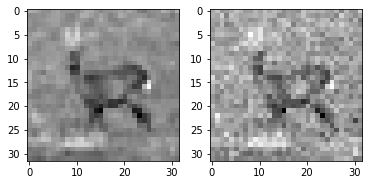

25  :  [0.4006335] 25
50  :  [0.4006335] 25
75  :  [0.41347143] 25
100  :  [0.41641346] 25
125  :  [0.41852936] 25
150  :  [0.41852936] 25
175  :  [0.41852936] 25
200  :  [0.41852936] 25
225  :  [0.41852936] 25
250  :  [0.41852936] 25
275  :  [0.41852936] 25
300  :  [0.41852936] 25
325  :  [0.41852936] 25
350  :  [0.41852936] 25
375  :  [0.41857553] 25
400  :  [0.41857553] 25
425  :  [0.41857553] 25
450  :  [0.421078] 25
475  :  [0.4216901] 25
500  :  [0.4216901] 25
525  :  [0.4216901] 25
550  :  [0.4221557] 25
575  :  [0.4221557] 25
600  :  [0.4249109] 25
625  :  [0.4249109] 25
650  :  [0.4258] 25
675  :  [0.4258] 25
700  :  [0.4258] 25
725  :  [0.4258] 25
750  :  [0.4258] 25
775  :  [0.4258] 25
800  :  [0.4258] 25
825  :  [0.4258] 25
850  :  [0.4258517] 25
875  :  [0.4259326] 25
900  :  [0.42601597] 25
925  :  [0.42614368] 25
950  :  [0.42614368] 25
975  :  [0.42614368] 25
1000  :  [0.4262743] 25
1025  :  [0.4262743] 25
1050  :  [0.4262743] 25
1075  :  [0.4262743] 25
1100  :  [0.4263

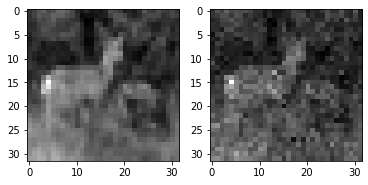

25  :  [0.3073226] 25
50  :  [0.3073226] 25
75  :  [0.3102458] 25
100  :  [0.3106137] 25
125  :  [0.31206906] 25
150  :  [0.31206834] 25
175  :  [0.3125552] 25
200  :  [0.3125299] 25
225  :  [0.3125299] 25
250  :  [0.3125299] 25
275  :  [0.3125299] 25
300  :  [0.3125299] 25
325  :  [0.3125299] 25
350  :  [0.3125299] 25
375  :  [0.3125299] 25
400  :  [0.3125299] 25
425  :  [0.3125299] 25
450  :  [0.3125299] 25
475  :  [0.31304437] 25
500  :  [0.31304437] 25
525  :  [0.31304437] 25
550  :  [0.3140945] 25
575  :  [0.3140874] 25
600  :  [0.31432796] 25
625  :  [0.3145135] 25
650  :  [0.31451356] 25
675  :  [0.31505853] 25
700  :  [0.3150741] 25
725  :  [0.3150741] 25
750  :  [0.31537455] 25
775  :  [0.31545627] 25
800  :  [0.31563073] 25
825  :  [0.31572056] 25
850  :  [0.31595767] 25
875  :  [0.31595767] 25
900  :  [0.31595767] 25
925  :  [0.31595767] 25
950  :  [0.3159779] 25
975  :  [0.31600052] 25
1000  :  [0.31603754] 25
1025  :  [0.31603754] 25
1050  :  [0.3160537] 25
1075  :  [0.316

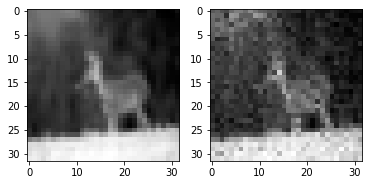

25  :  [-0.17274225] 25
50  :  [-0.10383494] 25
75  :  [0.2224644] 25
100  :  [0.2224644] 25
125  :  [0.24015641] 25
150  :  [0.23903364] 25
175  :  [0.23903364] 25
200  :  [0.24563408] 25
225  :  [0.24983484] 25
250  :  [0.28982472] 25
275  :  [0.28982472] 25
300  :  [0.29471734] 25
325  :  [0.29465842] 25
350  :  [0.31156975] 25
375  :  [0.3105631] 25
400  :  [0.31519544] 25
425  :  [0.31519544] 25
450  :  [0.32681966] 25
475  :  [0.32820082] 25
500  :  [0.32874277] 25
525  :  [0.32874277] 25
550  :  [0.32874277] 25
575  :  [0.3301317] 25
600  :  [0.33084553] 25
625  :  [0.3308998] 25
650  :  [0.33295804] 25
675  :  [0.33313853] 25
700  :  [0.3346576] 25
725  :  [0.33465862] 25
750  :  [0.33501917] 25
775  :  [0.33501917] 25
800  :  [0.33527339] 25
825  :  [0.3352192] 25
850  :  [0.33573186] 25
875  :  [0.33576062] 25
900  :  [0.3360337] 25
925  :  [0.3360337] 25
950  :  [0.3365595] 25
975  :  [0.33665293] 25
1000  :  [0.33688593] 25
1025  :  [0.33698943] 25
1050  :  [0.33728683] 25


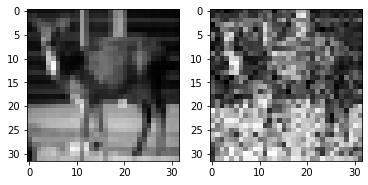

25  :  [0.3314138] 25
50  :  [0.35299796] 25
75  :  [0.35419536] 25
100  :  [0.35419536] 25
125  :  [0.35419536] 25
150  :  [0.3609132] 25
175  :  [0.36101076] 25
200  :  [0.36101076] 25
225  :  [0.36101076] 25
250  :  [0.36101076] 25
275  :  [0.36101076] 25
300  :  [0.36101076] 25
325  :  [0.36130953] 25
350  :  [0.36186767] 25
375  :  [0.36230198] 25
400  :  [0.36244607] 25
425  :  [0.36356753] 25
450  :  [0.36356753] 25
475  :  [0.36356753] 25
500  :  [0.36356753] 25
525  :  [0.3638545] 25
550  :  [0.3638545] 25
575  :  [0.3638545] 25
600  :  [0.3639242] 25
625  :  [0.364119] 25
650  :  [0.3641736] 25
675  :  [0.36418167] 25
700  :  [0.36423695] 25
725  :  [0.36425045] 25
750  :  [0.36438423] 25
775  :  [0.3644274] 25
800  :  [0.3644657] 25
825  :  [0.3645296] 25
850  :  [0.3645296] 25
875  :  [0.36464733] 25
900  :  [0.36467034] 25
925  :  [0.36475283] 25
950  :  [0.3648058] 25
975  :  [0.36482936] 25
1000  :  [0.36485666] 25
1025  :  [0.36487633] 25
1050  :  [0.3648774] 25
1075  :

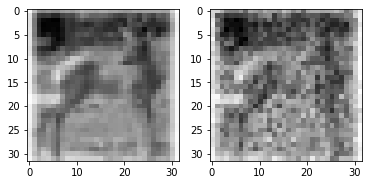

25  :  [0.28533748] 25
50  :  [0.33564007] 25
75  :  [0.3357532] 25
100  :  [0.3357532] 25
125  :  [0.3357532] 25
150  :  [0.3357532] 25
175  :  [0.3357532] 25
200  :  [0.3357532] 25
225  :  [0.3357532] 25
250  :  [0.3357532] 25
275  :  [0.3357532] 25
300  :  [0.3357532] 25
325  :  [0.3357532] 25
350  :  [0.3357532] 25
375  :  [0.3357532] 25
400  :  [0.3357532] 25
425  :  [0.3357532] 25
450  :  [0.3357532] 25
475  :  [0.3357532] 25
500  :  [0.3357532] 25
525  :  [0.3357532] 25
550  :  [0.3357532] 25
575  :  [0.3357532] 25
600  :  [0.3357532] 25
625  :  [0.3357532] 25
650  :  [0.3357532] 25
675  :  [0.3357532] 25
700  :  [0.3357532] 25
725  :  [0.3357532] 25
750  :  [0.3357532] 25
775  :  [0.3357532] 25
800  :  [0.3357532] 25
NOT IMPROVING!  825  :  [0.3357532] 25
Time:  239.22595047950745  seconds
Predicted class:  [2]


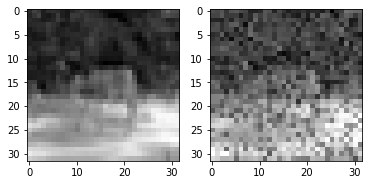

25  :  [0.3905123] 25
50  :  [0.3905123] 25
75  :  [0.3932066] 25
100  :  [0.3943242] 25
125  :  [0.3943242] 25
150  :  [0.39435893] 25
175  :  [0.39435893] 25
200  :  [0.39435893] 25
225  :  [0.39472276] 25
250  :  [0.39472276] 25
275  :  [0.395193] 25
300  :  [0.395193] 25
325  :  [0.395193] 25
350  :  [0.395193] 25
375  :  [0.39539257] 25
400  :  [0.395396] 25
425  :  [0.39586583] 25
450  :  [0.39586583] 25
475  :  [0.39598915] 25
500  :  [0.39623004] 25
525  :  [0.39623004] 25
550  :  [0.39623004] 25
575  :  [0.39625037] 25
600  :  [0.3966159] 25
625  :  [0.3966159] 25
650  :  [0.3966159] 25
675  :  [0.396898] 25
700  :  [0.396898] 25
725  :  [0.396898] 25
750  :  [0.39694893] 25
775  :  [0.3970289] 25
800  :  [0.3970384] 25
825  :  [0.39728495] 25
850  :  [0.39729124] 25
NOT IMPROVING!  875  :  [0.3973074] 25
Time:  236.58318758010864  seconds
Predicted class:  [2]


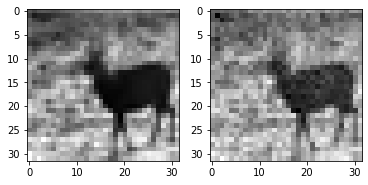

25  :  [0.41293308] 25
50  :  [0.41293308] 25
75  :  [0.41293308] 25
100  :  [0.41293308] 25
125  :  [0.41293308] 25
150  :  [0.41293308] 25
175  :  [0.41293308] 25
200  :  [0.41293308] 25
225  :  [0.41328058] 25
250  :  [0.41328058] 25
275  :  [0.41375217] 25
300  :  [0.41375217] 25
325  :  [0.41375217] 25
350  :  [0.41423237] 25
375  :  [0.41456842] 25
400  :  [0.41461235] 25
425  :  [0.41513443] 25
450  :  [0.41513443] 25
475  :  [0.41513443] 25
500  :  [0.4153685] 25
525  :  [0.4153685] 25
550  :  [0.4153685] 25
575  :  [0.41556114] 25
600  :  [0.41557693] 25
625  :  [0.41571307] 25
650  :  [0.4158094] 25
675  :  [0.41586152] 25
700  :  [0.41590214] 25
725  :  [0.4159202] 25
750  :  [0.4159352] 25
775  :  [0.415942] 25
NOT IMPROVING!  800  :  [0.415942] 25
Time:  219.22019624710083  seconds
Predicted class:  [2]


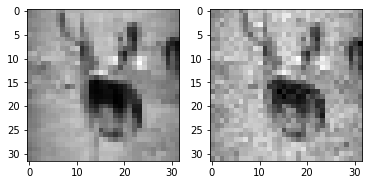

25  :  [0.377402] 25
50  :  [0.38276663] 25
75  :  [0.38276663] 25
100  :  [0.38276663] 25
125  :  [0.39881352] 25
150  :  [0.405083] 25
175  :  [0.405083] 25
200  :  [0.405083] 25
225  :  [0.405083] 25
250  :  [0.405083] 25
275  :  [0.405083] 25
300  :  [0.405083] 25
325  :  [0.405083] 25
350  :  [0.405083] 25
375  :  [0.405083] 25
400  :  [0.405083] 25
425  :  [0.405083] 25
450  :  [0.405083] 25
475  :  [0.405083] 25
500  :  [0.405083] 25
525  :  [0.405083] 25
550  :  [0.405083] 25
575  :  [0.405083] 25
600  :  [0.405083] 25
625  :  [0.405083] 25
650  :  [0.405083] 25
675  :  [0.405083] 25
700  :  [0.405083] 25
725  :  [0.405083] 25
750  :  [0.405083] 25
775  :  [0.405083] 25
800  :  [0.405083] 25
825  :  [0.405083] 25
850  :  [0.405083] 25
875  :  [0.405083] 25
900  :  [0.405083] 25
NOT IMPROVING!  925  :  [0.405083] 25
Time:  251.98421478271484  seconds
Predicted class:  [6]


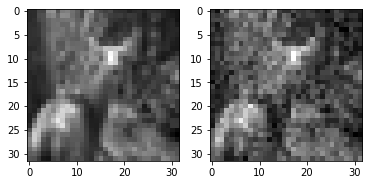

25  :  [0.44316885] 25
FOUND!  50  :  [0.4443652] 25
Time:  13.802931547164917  seconds
Predicted class:  [2]


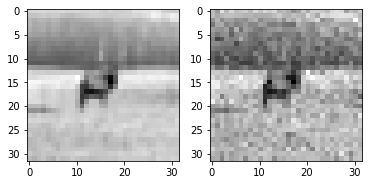

25  :  [0.35297376] 25
50  :  [0.35297376] 25
75  :  [0.35297376] 25
100  :  [0.36865544] 25
125  :  [0.36865544] 25
150  :  [0.36865544] 25
175  :  [0.36865544] 25
200  :  [0.36865544] 25
225  :  [0.37237749] 25
250  :  [0.37237749] 25
275  :  [0.37237749] 25
300  :  [0.37237749] 25
325  :  [0.3731201] 25
350  :  [0.3740571] 25
375  :  [0.3740711] 25
400  :  [0.3740711] 25
425  :  [0.3740711] 25
450  :  [0.3740711] 25
475  :  [0.3740711] 25
500  :  [0.3740711] 25
525  :  [0.3740711] 25
550  :  [0.37980002] 25
575  :  [0.37980002] 25
600  :  [0.3828528] 25
625  :  [0.3828528] 25
650  :  [0.3828528] 25
675  :  [0.3842481] 25
700  :  [0.3842481] 25
725  :  [0.3842481] 25
750  :  [0.38599002] 25
775  :  [0.38600653] 25
800  :  [0.38600653] 25
825  :  [0.38600653] 25
850  :  [0.38600653] 25
875  :  [0.38600653] 25
900  :  [0.38645467] 25
925  :  [0.38703603] 25
950  :  [0.38703603] 25
975  :  [0.38709748] 25
1000  :  [0.3876241] 25
1025  :  [0.38781157] 25
1050  :  [0.3879751] 25
1075  :  

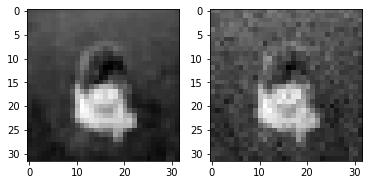

25  :  [0.29233482] 25
50  :  [0.3120115] 25
75  :  [0.36051026] 25
100  :  [0.36016294] 25
125  :  [0.36154738] 25
150  :  [0.36144444] 25
175  :  [0.36144444] 25
200  :  [0.36144444] 25
225  :  [0.36144444] 25
250  :  [0.36144444] 25
275  :  [0.36441243] 25
300  :  [0.3642088] 25
325  :  [0.36922568] 25
350  :  [0.36922568] 25
375  :  [0.36922568] 25
400  :  [0.36922568] 25
425  :  [0.36922568] 25
450  :  [0.36922568] 25
475  :  [0.37230557] 25
500  :  [0.37226242] 25
525  :  [0.37226242] 25
550  :  [0.37226242] 25
575  :  [0.37226242] 25
600  :  [0.37226242] 25
625  :  [0.37226242] 25
650  :  [0.3732118] 25
675  :  [0.373124] 25
700  :  [0.373124] 25
725  :  [0.373124] 25
750  :  [0.373124] 25
775  :  [0.373124] 25
800  :  [0.373124] 25
825  :  [0.37492108] 25
850  :  [0.37492108] 25
875  :  [0.3783605] 25
900  :  [0.37940383] 25
925  :  [0.38046452] 25
950  :  [0.38120306] 25
975  :  [0.38120306] 25
1000  :  [0.38120306] 25
1025  :  [0.38120306] 25
1050  :  [0.38160533] 25
1075  : 

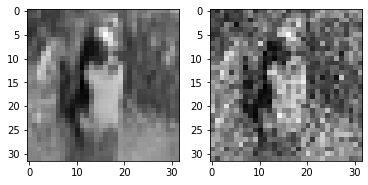

25  :  [0.3603154] 25
50  :  [0.36424005] 25
75  :  [0.3643465] 25
100  :  [0.3643465] 25
125  :  [0.36527404] 25
150  :  [0.365274] 25
175  :  [0.365274] 25
200  :  [0.3653428] 25
225  :  [0.3658767] 25
250  :  [0.36632088] 25
275  :  [0.36632088] 25
300  :  [0.36632088] 25
325  :  [0.36688977] 25
350  :  [0.36720335] 25
375  :  [0.36764583] 25
400  :  [0.36764693] 25
425  :  [0.3680057] 25
450  :  [0.3680215] 25
475  :  [0.3681012] 25
500  :  [0.36826843] 25
525  :  [0.3682887] 25
550  :  [0.36852685] 25
575  :  [0.36852685] 25
600  :  [0.36852685] 25
625  :  [0.3686483] 25
650  :  [0.3687278] 25
675  :  [0.36876294] 25
700  :  [0.36876294] 25
725  :  [0.36876512] 25
750  :  [0.36883432] 25
775  :  [0.36889648] 25
800  :  [0.36889648] 25
NOT IMPROVING!  825  :  [0.3690015] 25
Time:  221.91275930404663  seconds
Predicted class:  [2]


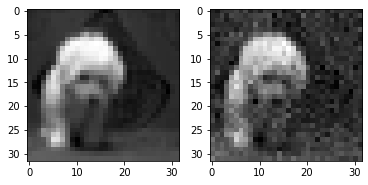

25  :  [0.33090657] 25
50  :  [0.33090657] 25
75  :  [0.33090657] 25
100  :  [0.33090657] 25
125  :  [0.33090657] 25
150  :  [0.33217037] 25
175  :  [0.34394512] 25
200  :  [0.34281796] 25
225  :  [0.34281796] 25
250  :  [0.34380183] 25
275  :  [0.3438381] 25
300  :  [0.3438381] 25
325  :  [0.3438381] 25
350  :  [0.34741682] 25
375  :  [0.34740403] 25
400  :  [0.34740403] 25
425  :  [0.34740403] 25
450  :  [0.350574] 25
475  :  [0.3506182] 25
500  :  [0.3506182] 25
525  :  [0.3506182] 25
550  :  [0.3506182] 25
575  :  [0.35101599] 25
600  :  [0.35101599] 25
625  :  [0.35101599] 25
650  :  [0.35101599] 25
675  :  [0.3512932] 25
700  :  [0.3512932] 25
725  :  [0.3513186] 25
750  :  [0.3515575] 25
775  :  [0.35402] 25
800  :  [0.35402] 25
825  :  [0.35402] 25
850  :  [0.35402] 25
875  :  [0.35402] 25
900  :  [0.35402] 25
925  :  [0.35411686] 25
950  :  [0.35411686] 25
975  :  [0.35411686] 25
1000  :  [0.35411686] 25
1025  :  [0.3541742] 25
1050  :  [0.35417885] 25
1075  :  [0.3541857] 25


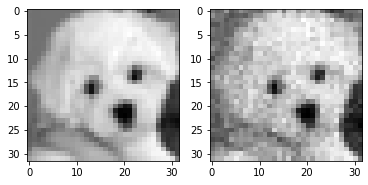

25  :  [0.3599308] 25
50  :  [0.36042294] 25
75  :  [0.36042294] 25
100  :  [0.36042294] 25
125  :  [0.36042294] 25
150  :  [0.36082363] 25
175  :  [0.36091512] 25
200  :  [0.36176246] 25
225  :  [0.36176246] 25
250  :  [0.3620039] 25
275  :  [0.3623973] 25
300  :  [0.3623973] 25
325  :  [0.3623973] 25
350  :  [0.3626536] 25
375  :  [0.3626536] 25
400  :  [0.36266452] 25
425  :  [0.3626926] 25
450  :  [0.36294183] 25
475  :  [0.36294183] 25
500  :  [0.36294183] 25
525  :  [0.36305356] 25
550  :  [0.36306313] 25
575  :  [0.36311603] 25
600  :  [0.36313975] 25
625  :  [0.36313975] 25
650  :  [0.36315137] 25
675  :  [0.36316228] 25
700  :  [0.36316228] 25
725  :  [0.36316228] 25
750  :  [0.36323014] 25
775  :  [0.3632344] 25
NOT IMPROVING!  800  :  [0.3632344] 25
Time:  219.49154686927795  seconds
Predicted class:  [2]


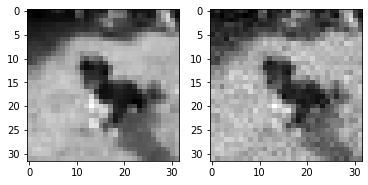

25  :  [0.3741699] 25
50  :  [0.3741699] 25
75  :  [0.3741699] 25
100  :  [0.37598592] 25
125  :  [0.37598592] 25
150  :  [0.38460928] 25
175  :  [0.38467786] 25
200  :  [0.38467786] 25
225  :  [0.38467786] 25
250  :  [0.38467786] 25
275  :  [0.38467786] 25
300  :  [0.38467786] 25
325  :  [0.38633358] 25
350  :  [0.38633358] 25
375  :  [0.38633358] 25
400  :  [0.38633358] 25
425  :  [0.38703772] 25
450  :  [0.38871586] 25
475  :  [0.3888309] 25
500  :  [0.3888309] 25
525  :  [0.38887998] 25
550  :  [0.38887998] 25
575  :  [0.38887998] 25
600  :  [0.38914952] 25
625  :  [0.3894682] 25
650  :  [0.3894682] 25
675  :  [0.38950515] 25
700  :  [0.3895525] 25
725  :  [0.38971126] 25
750  :  [0.38976878] 25
775  :  [0.3898239] 25
800  :  [0.39002198] 25
825  :  [0.39006197] 25
850  :  [0.39014393] 25
875  :  [0.3901626] 25
900  :  [0.39019352] 25
925  :  [0.3902505] 25
950  :  [0.39025772] 25
975  :  [0.39028603] 25
1000  :  [0.3903599] 25
1025  :  [0.39038244] 25
1050  :  [0.39043158] 25
1075

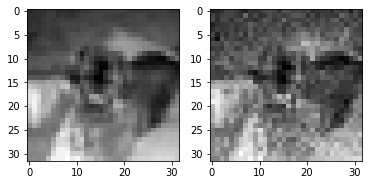

25  :  [0.33662444] 25
50  :  [0.3369975] 25
75  :  [0.33776778] 25
100  :  [0.33776778] 25
125  :  [0.33776778] 25
150  :  [0.33776778] 25
175  :  [0.34585297] 25
200  :  [0.34776843] 25
225  :  [0.34912884] 25
250  :  [0.34912884] 25
275  :  [0.3514438] 25
300  :  [0.35225192] 25
325  :  [0.35225192] 25
350  :  [0.35231164] 25
375  :  [0.35376886] 25
400  :  [0.3538916] 25
425  :  [0.35589266] 25
450  :  [0.35620227] 25
475  :  [0.35656595] 25
500  :  [0.3574344] 25
525  :  [0.35781425] 25
550  :  [0.35792336] 25
575  :  [0.3580813] 25
600  :  [0.35818803] 25
625  :  [0.3582253] 25
650  :  [0.35862225] 25
675  :  [0.35868344] 25
700  :  [0.35894826] 25
725  :  [0.35920063] 25
750  :  [0.35920063] 25
775  :  [0.35920063] 25
800  :  [0.35928866] 25
825  :  [0.35928866] 25
850  :  [0.35946763] 25
875  :  [0.35953853] 25
900  :  [0.35953853] 25
925  :  [0.3595631] 25
950  :  [0.3595747] 25
975  :  [0.3595747] 25
1000  :  [0.35958594] 25
1025  :  [0.35958594] 25
1050  :  [0.35959616] 25
1

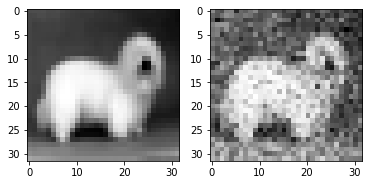

25  :  [0.3191833] 25
50  :  [0.3191833] 25
75  :  [0.3191833] 25
100  :  [0.32251433] 25
125  :  [0.33233106] 25
150  :  [0.33254322] 25
175  :  [0.33254322] 25
200  :  [0.33254322] 25
225  :  [0.33254322] 25
250  :  [0.3357821] 25
275  :  [0.33578217] 25
300  :  [0.33578217] 25
325  :  [0.33578217] 25
350  :  [0.33578217] 25
375  :  [0.33578217] 25
400  :  [0.33578217] 25
425  :  [0.33645636] 25
450  :  [0.33645636] 25
475  :  [0.33645636] 25
500  :  [0.33645636] 25
525  :  [0.33645636] 25
550  :  [0.33645636] 25
575  :  [0.33732188] 25
600  :  [0.33732188] 25
625  :  [0.33732188] 25
650  :  [0.33732188] 25
675  :  [0.33732188] 25
700  :  [0.33732188] 25
725  :  [0.33732188] 25
750  :  [0.33732188] 25
775  :  [0.33732188] 25
800  :  [0.33732188] 25
825  :  [0.33732188] 25
850  :  [0.3373952] 25
875  :  [0.3373952] 25
900  :  [0.3373952] 25
925  :  [0.33764404] 25
950  :  [0.33764404] 25
975  :  [0.33768943] 25
1000  :  [0.33799714] 25
NOT IMPROVING!  1025  :  [0.3382336] 25
Time:  28

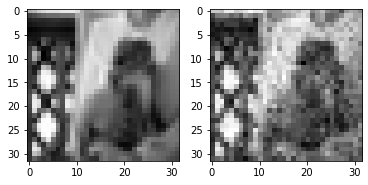

25  :  [0.2317813] 25
50  :  [0.2317813] 25
75  :  [0.25919533] 25
100  :  [0.27211118] 25
125  :  [0.27471107] 25
150  :  [0.28207076] 25
175  :  [0.28775704] 25
200  :  [0.28775704] 25
225  :  [0.28775704] 25
250  :  [0.28775704] 25
275  :  [0.28775704] 25
300  :  [0.2918558] 25
325  :  [0.29188192] 25
350  :  [0.29188192] 25
375  :  [0.29188192] 25
400  :  [0.29188192] 25
425  :  [0.29188192] 25
450  :  [0.29188192] 25
475  :  [0.29188192] 25
500  :  [0.29188192] 25
525  :  [0.29188192] 25
550  :  [0.29188192] 25
575  :  [0.29188192] 25
600  :  [0.29188192] 25
625  :  [0.29188192] 25
650  :  [0.29188192] 25
675  :  [0.29249364] 25
700  :  [0.29315734] 25
725  :  [0.2935305] 25
750  :  [0.29369742] 25
775  :  [0.29369742] 25
800  :  [0.29369742] 25
825  :  [0.29370046] 25
850  :  [0.29385096] 25
875  :  [0.29479986] 25
900  :  [0.29479986] 25
925  :  [0.2948147] 25
950  :  [0.2948147] 25
975  :  [0.29492941] 25
1000  :  [0.29494786] 25
1025  :  [0.29494786] 25
1050  :  [0.29494786] 2

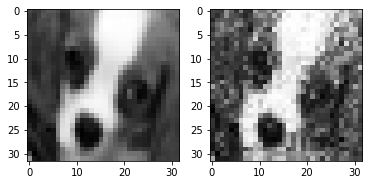

25  :  [0.28817362] 25
50  :  [0.28817362] 25
75  :  [0.32134068] 25
100  :  [0.31618488] 25
125  :  [0.31618488] 25
150  :  [0.31618488] 25
175  :  [0.31618488] 25
200  :  [0.3162892] 25
225  :  [0.31911036] 25
250  :  [0.3185563] 25
275  :  [0.3185563] 25
300  :  [0.32154065] 25
325  :  [0.3241148] 25
350  :  [0.3278461] 25
375  :  [0.32790095] 25
400  :  [0.32790095] 25
425  :  [0.32790095] 25
450  :  [0.33091193] 25
475  :  [0.3309561] 25
500  :  [0.3309561] 25
525  :  [0.3309561] 25
550  :  [0.3309561] 25
575  :  [0.33455247] 25
600  :  [0.33455247] 25
625  :  [0.33455247] 25
650  :  [0.33455247] 25
675  :  [0.33563203] 25
700  :  [0.33563203] 25
725  :  [0.335888] 25
750  :  [0.3366928] 25
775  :  [0.3366928] 25
800  :  [0.33682293] 25
825  :  [0.3371801] 25
850  :  [0.33785754] 25
875  :  [0.33785754] 25
900  :  [0.33828676] 25
925  :  [0.33828676] 25
950  :  [0.33848435] 25
975  :  [0.33848435] 25
1000  :  [0.33848435] 25
1025  :  [0.3385669] 25
1050  :  [0.33868796] 25
1075  :

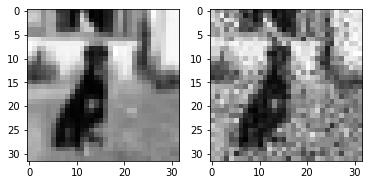

25  :  [0.26611066] 25
50  :  [0.26611066] 25
75  :  [0.27618885] 25
100  :  [0.27688605] 25
125  :  [0.27688605] 25
150  :  [0.27782416] 25
175  :  [0.27782416] 25
200  :  [0.28232062] 25
225  :  [0.28199887] 25
250  :  [0.28259522] 25
275  :  [0.285828] 25
300  :  [0.285828] 25
325  :  [0.285828] 25
350  :  [0.285828] 25
375  :  [0.2888901] 25
400  :  [0.2888901] 25
425  :  [0.29194713] 25
450  :  [0.2927859] 25
475  :  [0.2930922] 25
500  :  [0.29350597] 25
525  :  [0.29414004] 25
550  :  [0.29414004] 25
575  :  [0.29429692] 25
600  :  [0.29432923] 25
625  :  [0.2951566] 25
650  :  [0.29527578] 25
675  :  [0.29551685] 25
700  :  [0.29552037] 25
725  :  [0.29552037] 25
750  :  [0.29552037] 25
775  :  [0.29570735] 25
800  :  [0.29611474] 25
825  :  [0.29613996] 25
850  :  [0.29613996] 25
875  :  [0.29613996] 25
900  :  [0.29631758] 25
925  :  [0.29631865] 25
950  :  [0.29635233] 25
975  :  [0.29641038] 25
1000  :  [0.29651982] 25
1025  :  [0.29652107] 25
1050  :  [0.29661018] 25
1075 

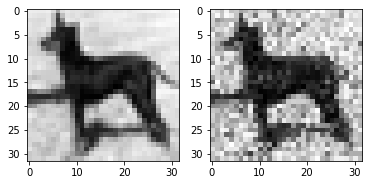

25  :  [0.24282974] 25
50  :  [0.25022808] 25
75  :  [0.2523306] 25
100  :  [0.26712322] 25
125  :  [0.2673108] 25
150  :  [0.2673108] 25
175  :  [0.2673108] 25
200  :  [0.2673108] 25
225  :  [0.2673108] 25
250  :  [0.2673108] 25
275  :  [0.2673108] 25
300  :  [0.26751286] 25
325  :  [0.2685446] 25
350  :  [0.27196768] 25
375  :  [0.27196768] 25
400  :  [0.27196768] 25
425  :  [0.27196768] 25
450  :  [0.27196768] 25
475  :  [0.27196768] 25
500  :  [0.27196768] 25
525  :  [0.27196768] 25
550  :  [0.27196768] 25
575  :  [0.2733518] 25
600  :  [0.27335194] 25
625  :  [0.27347213] 25
650  :  [0.27438077] 25
675  :  [0.27438077] 25
700  :  [0.27438077] 25
725  :  [0.27438077] 25
750  :  [0.27438077] 25
775  :  [0.27443635] 25
800  :  [0.27446675] 25
825  :  [0.27455056] 25
850  :  [0.2746175] 25
875  :  [0.2746279] 25
900  :  [0.2747187] 25
925  :  [0.2747469] 25
950  :  [0.2747686] 25
975  :  [0.27482796] 25
1000  :  [0.27483475] 25
1025  :  [0.27488446] 25
1050  :  [0.27490965] 25
1075  :

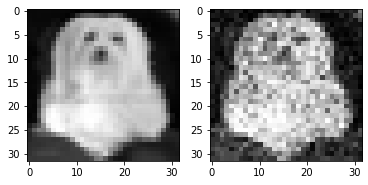

25  :  [0.21091226] 25
50  :  [0.21091226] 25
75  :  [0.2188878] 25
100  :  [0.24741365] 25
125  :  [0.24899706] 25
150  :  [0.24899706] 25
175  :  [0.24899706] 25
200  :  [0.24899706] 25
225  :  [0.24899706] 25
250  :  [0.25379175] 25
275  :  [0.25399595] 25
300  :  [0.25399595] 25
325  :  [0.2597044] 25
350  :  [0.2598742] 25
375  :  [0.25997734] 25
400  :  [0.2622528] 25
425  :  [0.26228136] 25
450  :  [0.26228136] 25
475  :  [0.26228136] 25
500  :  [0.26314616] 25
525  :  [0.26317674] 25
550  :  [0.2632049] 25
575  :  [0.2632049] 25
600  :  [0.2632049] 25
625  :  [0.26368228] 25
650  :  [0.26368228] 25
675  :  [0.26368228] 25
700  :  [0.26368228] 25
725  :  [0.26368228] 25
750  :  [0.2638542] 25
775  :  [0.26447266] 25
800  :  [0.26447353] 25
825  :  [0.26447353] 25
850  :  [0.26447353] 25
875  :  [0.26449293] 25
900  :  [0.26451218] 25
925  :  [0.26466322] 25
950  :  [0.26470065] 25
975  :  [0.26470065] 25
1000  :  [0.26470065] 25
1025  :  [0.26470065] 25
1050  :  [0.26471165] 25


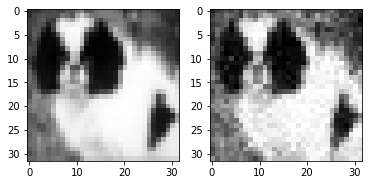

25  :  [0.34896865] 25
50  :  [0.3510148] 25
75  :  [0.35101494] 25
100  :  [0.35101494] 25
125  :  [0.35101494] 25
150  :  [0.3513055] 25
175  :  [0.3513055] 25
200  :  [0.35293102] 25
225  :  [0.35293102] 25
250  :  [0.35293102] 25
275  :  [0.35300142] 25
300  :  [0.3530495] 25
325  :  [0.3530495] 25
350  :  [0.35331795] 25
375  :  [0.35332865] 25
400  :  [0.3535247] 25
425  :  [0.35373175] 25
450  :  [0.35392514] 25
475  :  [0.35392514] 25
500  :  [0.35392514] 25
525  :  [0.3539495] 25
550  :  [0.3539684] 25
575  :  [0.35420525] 25
600  :  [0.3542832] 25
625  :  [0.3542832] 25
650  :  [0.3543312] 25
675  :  [0.35434312] 25
700  :  [0.35445762] 25
725  :  [0.35450935] 25
750  :  [0.35450935] 25
775  :  [0.3546127] 25
800  :  [0.3546127] 25
825  :  [0.3546183] 25
850  :  [0.35466087] 25
875  :  [0.35466945] 25
900  :  [0.354697] 25
925  :  [0.3547595] 25
950  :  [0.35477835] 25
NOT IMPROVING!  975  :  [0.35482806] 25
Time:  270.5271441936493  seconds
Predicted class:  [3]


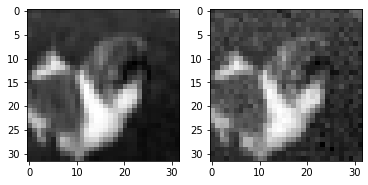

25  :  [-0.32178319] 25
50  :  [-0.1129896] 25
75  :  [-0.02435501] 25
100  :  [0.11275199] 25
125  :  [0.17732817] 25
150  :  [0.26051372] 25
175  :  [0.24880752] 25
200  :  [0.24880752] 25
225  :  [0.27717382] 25
250  :  [0.2873391] 25
275  :  [0.27761638] 25
300  :  [0.2935549] 25
325  :  [0.31515193] 25
350  :  [0.31515193] 25
375  :  [0.31663465] 25
400  :  [0.31679153] 25
425  :  [0.3206969] 25
450  :  [0.3206969] 25
475  :  [0.3206969] 25
500  :  [0.3206969] 25
525  :  [0.32231706] 25
550  :  [0.32231706] 25
575  :  [0.32231706] 25
600  :  [0.32287413] 25
625  :  [0.32590553] 25
650  :  [0.32568553] 25
675  :  [0.32675052] 25
700  :  [0.32770604] 25
725  :  [0.32787246] 25
750  :  [0.32930055] 25
775  :  [0.3295567] 25
800  :  [0.3302378] 25
825  :  [0.33096945] 25
850  :  [0.33096945] 25
875  :  [0.33128014] 25
900  :  [0.33237898] 25
925  :  [0.3335765] 25
950  :  [0.33359504] 25
975  :  [0.33489808] 25
1000  :  [0.3349293] 25
1025  :  [0.3349293] 25
1050  :  [0.33570814] 25
1

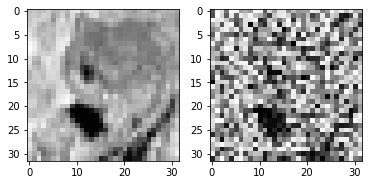

25  :  [0.26739645] 25
50  :  [0.33123243] 25
75  :  [0.33123243] 25
100  :  [0.33123243] 25
125  :  [0.35005143] 25
150  :  [0.35005143] 25
175  :  [0.35005143] 25
200  :  [0.35005143] 25
225  :  [0.35514754] 25
250  :  [0.36182886] 25
275  :  [0.36642748] 25
300  :  [0.3685942] 25
325  :  [0.3685942] 25
350  :  [0.3685942] 25
375  :  [0.3685942] 25
400  :  [0.3701232] 25
425  :  [0.3701232] 25
450  :  [0.3701232] 25
475  :  [0.3701232] 25
500  :  [0.3701232] 25
525  :  [0.3701232] 25
550  :  [0.3701232] 25
575  :  [0.3701232] 25
600  :  [0.3701232] 25
625  :  [0.3701232] 25
650  :  [0.3701232] 25
675  :  [0.3701232] 25
700  :  [0.3701232] 25
725  :  [0.3701232] 25
750  :  [0.3701232] 25
775  :  [0.3701232] 25
800  :  [0.3701232] 25
825  :  [0.3701232] 25
850  :  [0.3701232] 25
875  :  [0.3701232] 25
900  :  [0.3701232] 25
925  :  [0.3701232] 25
950  :  [0.3701232] 25
975  :  [0.3701232] 25
1000  :  [0.3701232] 25
1025  :  [0.3701232] 25
1050  :  [0.3701232] 25
1075  :  [0.3701232] 25

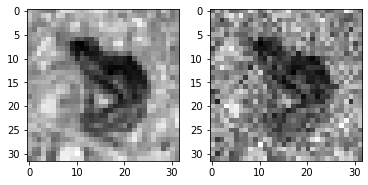

25  :  [0.40473104] 25
50  :  [0.4123043] 25
75  :  [0.4123043] 25
100  :  [0.4123043] 25
125  :  [0.4123043] 25
150  :  [0.4123043] 25
175  :  [0.4123043] 25
200  :  [0.41977957] 25
225  :  [0.41977957] 25
250  :  [0.41977957] 25
275  :  [0.41977957] 25
300  :  [0.41977957] 25
325  :  [0.41977957] 25
350  :  [0.41977957] 25
375  :  [0.41977957] 25
400  :  [0.41977957] 25
425  :  [0.42029494] 25
450  :  [0.42029494] 25
475  :  [0.42029494] 25
500  :  [0.42029494] 25
525  :  [0.42029494] 25
550  :  [0.42029494] 25
575  :  [0.42029494] 25
600  :  [0.4216864] 25
625  :  [0.42191684] 25
650  :  [0.42191684] 25
675  :  [0.42479616] 25
700  :  [0.42485285] 25
725  :  [0.42656603] 25
750  :  [0.42656603] 25
775  :  [0.42656603] 25
800  :  [0.42671853] 25
825  :  [0.42844424] 25
850  :  [0.42844424] 25
875  :  [0.42844424] 25
900  :  [0.42844424] 25
925  :  [0.42844424] 25
950  :  [0.42844424] 25
975  :  [0.42844424] 25
1000  :  [0.4285367] 25
1025  :  [0.4285367] 25
1050  :  [0.42868003] 25
1

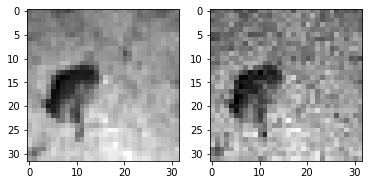

25  :  [0.01272681] 25
50  :  [0.12812795] 25
75  :  [0.12844591] 25
100  :  [0.17972687] 25
125  :  [0.24711633] 25
150  :  [0.22455502] 25
175  :  [0.2325463] 25
200  :  [0.30101573] 25
225  :  [0.30820173] 25
250  :  [0.30820173] 25
275  :  [0.30820173] 25
300  :  [0.30820173] 25
325  :  [0.30820173] 25
350  :  [0.30820173] 25
375  :  [0.30820173] 25
400  :  [0.31013584] 25
425  :  [0.31013584] 25
450  :  [0.31013584] 25
475  :  [0.31013584] 25
500  :  [0.31262505] 25
525  :  [0.31512147] 25
550  :  [0.31980008] 25
575  :  [0.31980008] 25
600  :  [0.32147518] 25
625  :  [0.32200927] 25
650  :  [0.32375973] 25
675  :  [0.32464266] 25
700  :  [0.32551324] 25
725  :  [0.32554907] 25
750  :  [0.3282205] 25
775  :  [0.33122614] 25
800  :  [0.33186933] 25
825  :  [0.33186933] 25
850  :  [0.33186933] 25
875  :  [0.3323049] 25
900  :  [0.3323049] 25
925  :  [0.3323894] 25
950  :  [0.33295998] 25
975  :  [0.3329943] 25
1000  :  [0.33332926] 25
1025  :  [0.3336317] 25
1050  :  [0.33388448] 25

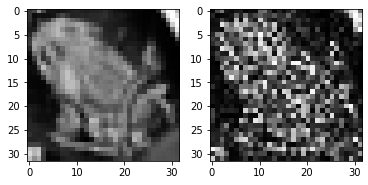

25  :  [0.264228] 25
50  :  [0.27561417] 25
75  :  [0.30580115] 25
100  :  [0.30580115] 25
125  :  [0.30580115] 25
150  :  [0.30580115] 25
175  :  [0.31796634] 25
200  :  [0.3083469] 25
225  :  [0.3083469] 25
250  :  [0.3083469] 25
275  :  [0.3083469] 25
300  :  [0.3083469] 25
325  :  [0.3083469] 25
350  :  [0.31669343] 25
375  :  [0.33567184] 25
400  :  [0.33567184] 25
425  :  [0.34512728] 25
450  :  [0.34512728] 25
475  :  [0.34512728] 25
500  :  [0.35003325] 25
525  :  [0.35003325] 25
550  :  [0.35003325] 25
575  :  [0.35003325] 25
600  :  [0.35003325] 25
625  :  [0.35003325] 25
650  :  [0.35003325] 25
675  :  [0.35003325] 25
700  :  [0.35003325] 25
725  :  [0.35003325] 25
750  :  [0.35003325] 25
775  :  [0.35003325] 25
800  :  [0.35038066] 25
825  :  [0.35038066] 25
850  :  [0.35280606] 25
875  :  [0.35642585] 25
900  :  [0.3564734] 25
925  :  [0.3564734] 25
950  :  [0.3564734] 25
975  :  [0.3566906] 25
1000  :  [0.3566906] 25
1025  :  [0.35746962] 25
1050  :  [0.35746962] 25
1075 

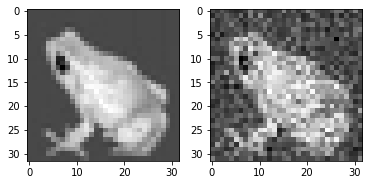

25  :  [0.11860216] 25
50  :  [0.11860216] 25
75  :  [0.2785672] 25
100  :  [0.28521317] 25
125  :  [0.28521317] 25
150  :  [0.28703523] 25
175  :  [0.28703523] 25
200  :  [0.28703523] 25
225  :  [0.2887597] 25
250  :  [0.2887597] 25
275  :  [0.2887597] 25
300  :  [0.2887597] 25
325  :  [0.2887597] 25
350  :  [0.28992704] 25
375  :  [0.28992704] 25
400  :  [0.29092246] 25
425  :  [0.29092246] 25
450  :  [0.2930924] 25
475  :  [0.2942445] 25
500  :  [0.2953384] 25
525  :  [0.29752806] 25
550  :  [0.29771963] 25
575  :  [0.29771963] 25
600  :  [0.29771963] 25
625  :  [0.29771963] 25
650  :  [0.29771963] 25
675  :  [0.2997324] 25
700  :  [0.2997349] 25
725  :  [0.2997349] 25
750  :  [0.2997349] 25
775  :  [0.2997349] 25
800  :  [0.2997349] 25
825  :  [0.2997349] 25
850  :  [0.3004115] 25
875  :  [0.3004115] 25
900  :  [0.30048683] 25
925  :  [0.30110365] 25
950  :  [0.30110365] 25
975  :  [0.3011572] 25
1000  :  [0.30127037] 25
1025  :  [0.30152553] 25
1050  :  [0.30152553] 25
1075  :  [0

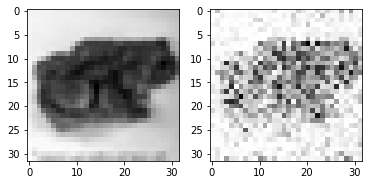

25  :  [0.14869036] 25
50  :  [0.14869036] 25
75  :  [0.25897145] 25
100  :  [0.25897145] 25
125  :  [0.269164] 25
150  :  [0.26174873] 25
175  :  [0.26197213] 25
200  :  [0.27124292] 25
225  :  [0.2764752] 25
250  :  [0.27710527] 25
275  :  [0.27710527] 25
300  :  [0.27710527] 25
325  :  [0.27710527] 25
350  :  [0.2806357] 25
375  :  [0.2806357] 25
400  :  [0.28239855] 25
425  :  [0.28239855] 25
450  :  [0.30037197] 25
475  :  [0.30054176] 25
500  :  [0.30074185] 25
525  :  [0.31932807] 25
550  :  [0.32023978] 25
575  :  [0.32021856] 25
600  :  [0.32021856] 25
625  :  [0.32021856] 25
650  :  [0.32021856] 25
675  :  [0.32021856] 25
700  :  [0.32222813] 25
725  :  [0.3219956] 25
750  :  [0.3219956] 25
775  :  [0.3219956] 25
800  :  [0.32240444] 25
825  :  [0.3225855] 25
850  :  [0.32798323] 25
875  :  [0.32798323] 25
900  :  [0.32798323] 25
925  :  [0.32798323] 25
950  :  [0.32948285] 25
975  :  [0.33112255] 25
1000  :  [0.33115518] 25
1025  :  [0.33115518] 25
1050  :  [0.33115518] 25
1

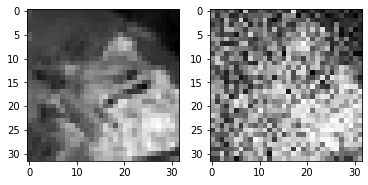

25  :  [-0.11387572] 25
50  :  [0.12437323] 25
75  :  [0.03954199] 25
100  :  [0.24445046] 25
125  :  [0.13764885] 25
150  :  [0.27566686] 25
175  :  [0.26483816] 25
200  :  [0.26483816] 25
225  :  [0.26483816] 25
250  :  [0.26483816] 25
275  :  [0.26483816] 25
300  :  [0.26483816] 25
325  :  [0.26483816] 25
350  :  [0.26483816] 25
375  :  [0.27355257] 25
400  :  [0.28173137] 25
425  :  [0.28245878] 25
450  :  [0.28836924] 25
475  :  [0.28836924] 25
500  :  [0.28836924] 25
525  :  [0.28847438] 25
550  :  [0.29665777] 25
575  :  [0.29665777] 25
600  :  [0.29665777] 25
625  :  [0.29665777] 25
650  :  [0.29665777] 25
675  :  [0.30382696] 25
700  :  [0.30382696] 25
725  :  [0.3058871] 25
750  :  [0.3061114] 25
775  :  [0.31018937] 25
800  :  [0.31016964] 25
825  :  [0.31154266] 25
850  :  [0.31624985] 25
875  :  [0.31665623] 25
900  :  [0.31681132] 25
925  :  [0.31990397] 25
950  :  [0.32092816] 25
975  :  [0.3209343] 25
1000  :  [0.3249619] 25
1025  :  [0.32691777] 25
1050  :  [0.3270107]

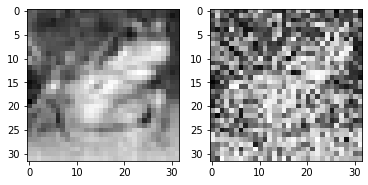

25  :  [0.0399399] 25
50  :  [0.08894069] 25
75  :  [0.06826907] 25
100  :  [0.06745529] 25
125  :  [0.14827496] 25
150  :  [0.225382] 25
175  :  [0.21614392] 25
200  :  [0.24436806] 25
225  :  [0.2815762] 25
250  :  [0.2815762] 25
275  :  [0.2815762] 25
300  :  [0.2815762] 25
325  :  [0.2815762] 25
350  :  [0.2815762] 25
375  :  [0.2815762] 25
400  :  [0.2815762] 25
425  :  [0.2833538] 25
450  :  [0.2989574] 25
475  :  [0.2989574] 25
500  :  [0.2989574] 25
525  :  [0.2989574] 25
550  :  [0.2989574] 25
575  :  [0.2989574] 25
600  :  [0.2989574] 25
625  :  [0.31456488] 25
650  :  [0.30546033] 25
675  :  [0.30546033] 25
700  :  [0.30546033] 25
725  :  [0.31596702] 25
750  :  [0.31603748] 25
775  :  [0.31603748] 25
800  :  [0.31603748] 25
825  :  [0.32199144] 25
850  :  [0.32704163] 25
875  :  [0.32910228] 25
900  :  [0.3295909] 25
925  :  [0.3307525] 25
950  :  [0.33210406] 25
975  :  [0.33210406] 25
1000  :  [0.33333033] 25
1025  :  [0.33640265] 25
1050  :  [0.33975667] 25
1075  :  [0.3

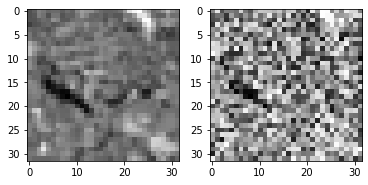

25  :  [-0.28434443] 25
50  :  [-0.11971612] 25
75  :  [0.13113558] 25
100  :  [0.18349984] 25
125  :  [0.27557737] 25
150  :  [0.20600319] 25
175  :  [0.20849709] 25
200  :  [0.20849709] 25
225  :  [0.2538172] 25
250  :  [0.26902646] 25
275  :  [0.3079288] 25
300  :  [0.3079288] 25
325  :  [0.3079288] 25
350  :  [0.3079288] 25
375  :  [0.32097363] 25
400  :  [0.32097363] 25
425  :  [0.32097363] 25
450  :  [0.32102537] 25
475  :  [0.32102537] 25
500  :  [0.32870132] 25
525  :  [0.32870132] 25
550  :  [0.32870132] 25
575  :  [0.32879406] 25
600  :  [0.32879406] 25
625  :  [0.32879406] 25
650  :  [0.32879406] 25
675  :  [0.32879406] 25
700  :  [0.32879406] 25
725  :  [0.33169192] 25
750  :  [0.33179957] 25
775  :  [0.33437952] 25
800  :  [0.33473915] 25
825  :  [0.3365066] 25
850  :  [0.33648628] 25
875  :  [0.33648628] 25
900  :  [0.33734566] 25
925  :  [0.33753806] 25
950  :  [0.33804646] 25
975  :  [0.33804646] 25
1000  :  [0.33821028] 25
1025  :  [0.3382801] 25
1050  :  [0.33838218] 

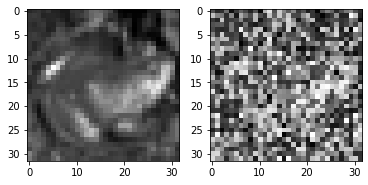

25  :  [-0.12069626] 25
50  :  [0.15393454] 25
75  :  [0.28151554] 25
100  :  [0.27371532] 25
125  :  [0.30027378] 25
150  :  [0.30027378] 25
175  :  [0.30027378] 25
200  :  [0.30027378] 25
225  :  [0.30027378] 25
250  :  [0.33035523] 25
275  :  [0.315839] 25
300  :  [0.315839] 25
325  :  [0.315839] 25
350  :  [0.3180173] 25
375  :  [0.3180173] 25
400  :  [0.3180173] 25
425  :  [0.3180173] 25
450  :  [0.32990605] 25
475  :  [0.33097413] 25
500  :  [0.33097413] 25
525  :  [0.3362028] 25
550  :  [0.3362028] 25
575  :  [0.3362028] 25
600  :  [0.3362028] 25
625  :  [0.34280968] 25
650  :  [0.34934735] 25
675  :  [0.34936023] 25
700  :  [0.34936023] 25
725  :  [0.34936023] 25
750  :  [0.3495034] 25
775  :  [0.35252333] 25
800  :  [0.356707] 25
825  :  [0.356707] 25
850  :  [0.35712296] 25
875  :  [0.35814095] 25
900  :  [0.35814095] 25
925  :  [0.35856998] 25
950  :  [0.35856998] 25
975  :  [0.35856998] 25
1000  :  [0.35902247] 25
1025  :  [0.35902247] 25
1050  :  [0.35902247] 25
1075  :  [

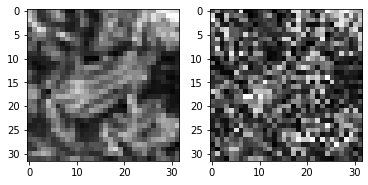

In [9]:
de_npc = DE_NPC(param_dict)
times = []
nfes = []
psnrs = []
predicted_classes = []
for adv_ind in range(91):
  de_npc.change_input(adversarial[adv_ind].reshape((32*32,1)),adversarial_y[adv_ind],32*32)
  timed, nfed = de_npc.execute(model)
  times.append(timed)
  nfes.append(nfed)
## increasing coefficient of the first term in fitness function and
## increasing the standard deviation of the noise increases the chance
## to find an adversarial example but it decreases the image quality
## of the adversarial example found
## also this algorithm can discard the best individual in the next generation
## to prevent this we can put it to population[0] after shuffling
  adv = np.clip(de_npc.X_best, 0, 255)
  psnrs.append(PSNR(adversarial[adv_ind],adv))
  preds_adv = model.predict(adv.reshape(1,32,32,1) / 255.0)
  predicted_classes.extend(np.argmax(preds_adv,axis=1))
  print("Predicted class: ",np.argmax(preds_adv,axis=1))
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(adversarial[adv_ind].reshape(32,32),cmap="gray")
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(de_npc.X_best.reshape(32,32),cmap="gray")
  plt.show()
  adversarial[adv_ind] = de_npc.X_best.reshape((32,32,1))

airplane										
automobile										
bird										
cat										
deer										
dog										
frog										
horse										
ship										
truck

In [0]:
file_ = open('adv_de_cnn_cifar_part1_seed1', 'wb')
pickle.dump(adversarial, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(predicted_classes, file_)
file_.close()

In [11]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))

563.8242526054382
13.802931547164917
344.8977699305985
114.6468614942943


In [12]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))

2199
50
1267.1868131868132
434.8068135400287


In [13]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))

22.821952628565015
5.607203649896906
11.4003452815554
3.02917671951084
